# Goal:

In this assignment, you will implement a [DDPM](https://arxiv.org/abs/2006.11239) class on MNIST dataset using PyTorch according to the guidence. The goal is to minimize the loss function and train the model to generate MNIST images.

The `Train` and `UNet` classes are already implemented for you. You need to implement the `DDPM` class (see details below). The images generated by the model will be automatically shown according to the `Trainer` class implementation. Make sure the generated images are shown in the output, it will be graded.

Grade:
- **DDPM class implementation (20 points).**
- **Training the model to generate reasonable MNIST images within 20 epochs (10 points).**
- **Write a report to describe include the sample images generated by each epochs (10 points). Please note that the function to generate the image is already provided.**
---
Please DO NOT change the code provided, only add your own code where indicated. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider using Kaggle GPU resource. Thank you and good luck!

# Pre-determined config and given functions (no need to change)

In [ ]:
!pip install labml_nn labml labml_helpers --no-deps
import torch
import torch.utils.data
import torchvision
from torch import nn
from labml_nn.diffusion.ddpm.unet import UNet
from typing import Tuple, Optional
import torch.nn.functional as F
from tqdm import tqdm
from easydict import EasyDict
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

args = {
    "image_channels": 1,  # Number of channels in the image. 3 for RGB.
    "image_size": 32,  # Image size
    "n_channels": 64,  # Number of channels in the initial feature map
    "channel_multipliers": [
        1,
        2,
        2,
        4,
    ],  # The list of channel numbers at each resolution.
    "is_attention": [
        False,
        False,
        False,
        True,
    ],  # The list of booleans for attention at each resolution
    "n_steps": 1000,  # Number of time steps T
    "nb_save": 5,  # Number of images to save
    "batch_size": 256,  # Batch size
    "n_samples": 16,  # Number of samples to generate
    "learning_rate": 2e-5,  # Learning rate
    "epochs": 20,  # Number of training epochs
    "device": "cuda" if torch.cuda.is_available() else "cpu",  # Device
    "fp16_precision": False
}
args = EasyDict(args)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
args.epochs

20

In [ ]:
class MNISTDataset(torchvision.datasets.MNIST):
    def __init__(self):
        transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(args.image_size),
                torchvision.transforms.ToTensor(),
            ]
        )

        super().__init__(
            ".", train=True, download=True, transform=transform
        )

    def __getitem__(self, item):
        return super().__getitem__(item)[0]

In [ ]:
class Trainer:
    def __init__(self, args, DenoiseDiffusion):

        self.eps_model = UNet(
            image_channels=args.image_channels,
            n_channels=args.n_channels,
            ch_mults=args.channel_multipliers,
            is_attn=args.is_attention,
        ).to(args.device)

        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=args.n_steps,
            device=args.device,
        )

        self.optimizer = torch.optim.Adam(
            self.eps_model.parameters(), lr=args.learning_rate
        )
        self.args = args

    def train_a_round(self, dataloader, scaler):
        for data in dataloader:
            # Move data to device
            data = data.to(args.device)

            # Calculate the loss
            with autocast(enabled=self.args.fp16_precision):
                loss = self.diffusion.loss(data)
                print(f"Loss: {loss}")
            # Zero gradients
            self.optimizer.zero_grad()
            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

    def run_in_a_row(self, dataloader):
        scaler = GradScaler(enabled=self.args.fp16_precision)
        for current_epoch in tqdm(range(self.args.epochs)):
            self.current_epoch = current_epoch
            self.train_a_round(dataloader, scaler)
            self.sample()

    def sample(self):
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn(
                [
                    self.args.n_samples,
                    self.args.image_channels,
                    self.args.image_size,
                    self.args.image_size,
                ],
                device=self.args.device,
            )
            if self.args.nb_save is not None:
                saving_steps = [self.args["n_steps"] - 1]
            # Remove noise for $T$ steps
            for t_ in tqdm(range(self.args.n_steps)):
                # $t$
                t = self.args.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.diffusion.p_sample(
                    x, x.new_full((self.args.n_samples,), t, dtype=torch.long)
                )
                if self.args.nb_save is not None and t_ in saving_steps:
                    print(f"Showing/saving samples from epoch {self.current_epoch}")
                    show_save(
                        x,
                        show=True,
                        save=True,
                        file_name=f"epoch_{self.current_epoch}_sample_{t_}.png",
                    )
        return x


def show_save(img_tensor, show=True, save=True, file_name="sample.png"):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Create a 4x4 grid of subplots
    assert img_tensor.shape[0] >= 9, "Number of images should be at least 9"
    img_tensor = img_tensor[:9]
    for i, ax in enumerate(axs.flat):
        # Remove the channel dimension and convert to numpy
        img = img_tensor[i].squeeze().cpu().numpy()

        ax.imshow(img, cmap="gray")  # Display the image in grayscale
        ax.axis("off")  # Hide the axis

    plt.tight_layout()
    if save:
        plt.savefig(file_name)
    if show:
        plt.show()
    plt.close(fig)

# Finish the DenoiseDiffusion model implementation

According to what the lecture is covered ([slides](https://www.dropbox.com/s/0gu91rovro71q90/Diffusion.pdf?dl=0)),

The `Trainer`, `dataset` and `UNet` are given.

We initialize ${\epsilon_\theta}(x_t, t)$, $\beta_1, \dots, \beta_T$ (linearly increasing variance schedule), $\alpha_t = 1 - \beta_t$, $\bar\alpha_t = \prod_{s=1}^t \alpha_s$, $\sigma^2 = \beta$
```python
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta
```

## q_xt_x0
We need to implment the function:
```python
    def q_xt_x0(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        return mean, var
```
\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

Hint: Use the given gather function. Read more about `gather()` [here](https://pytorch.org/docs/stable/generated/torch.gather.html).

## q_sample

We need to implment the function to get samples from $q(x_t|x_0)$.

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

Hint: sampling from $\mathcal{N} \Big(\mu, \sigma^2\Big)$ is the same as sampling from $\mathcal{N} \Big(0, I\Big)$ then scale and shift.

## p_sample
We need to implment the function to get samples from ${p_\theta}(x_{t-1}|x_t)$

\begin{align}
{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
{\mu_\theta}(x_t, t)
  &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
    \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}{\epsilon_\theta}(x_t, t) \Big)
\end{align}

*   `beta` is defined as $1-\alpha_t$  
*   `eps_coef` is defined as $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
*   `mu_theta` is defined as $\frac{1}{\sqrt{\alpha_t}} \Big(x_t -\frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)$
*   `var` is defined as $\sigma_t^2 \mathbf{I}$

## loss
We need to implment the function to get the loss:
$$L(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - {\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$

where `x_t` is sampled from $q(x_t|x_0)$ which is given by $\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon$


In [ ]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def gather(self, c: torch.Tensor, t: torch.Tensor):
        c_ = c.gather(-1, t)
        return c_.reshape(-1, 1, 1, 1)

    def q_xt_x0(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # TODO
        # alpha_bar
        alpha_bar_t = self.gather(self.alpha_bar, t)
        #compute the mean
        mean = alpha_bar_t.sqrt() * x0
        #compute the var
        var = (1 - alpha_bar_t)
      #  print(var.shape)
        return mean, var

    def q_sample(
        self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None
    ):
        if eps is None:
            eps = torch.randn_like(x0)
        # TODO
        mean, var = self.q_xt_x0(x0, t)
        sample = mean + eps * (var ** 0.5)

        return sample

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        # TODO
        alpha_bar = self.alpha_bar[t].reshape(-1,1,1,1)
        alpha = self.alpha[t].reshape(-1,1,1,1)
        beta = self.beta[t].reshape(-1,1,1,1)
        eps_coef = (beta) / (torch.sqrt(1 - alpha_bar))
        mu_theta = (1/torch.sqrt(alpha)) *(xt -eps_coef * eps_theta)

        var = self.sigma2[t].reshape(-1,1,1,1)
        eps = torch.randn(xt.shape, device=xt.device)
        sample = mu_theta + (var ** 0.5) * eps
        return sample

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(
            0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long
        )
        if noise is None:
            noise = torch.randn_like(x0)
        # TODO
        xt = self.q_sample(x0, t, noise)
        eps_theta = self.eps_model(xt, t)
        loss = nn.MSELoss()(eps_theta,noise)
        return loss


# Start training when you finish filling the code above
Expected time: About `400s` for each epoch (`20 epoches` in total), if you don't change the config parameters. No model-checkpoint-saving logic is implemented. Please feel free to implement it if you need it. There will be samples displayed and saved (in `.png` images) during training for every epoch. You should be able to find the saved images in the `Files` on the left hand side if you are using Google colab.

Notice: `20 epoches` in total is just a safe setting to generate MNIST-style images. Usually, it should start to generate interpretable images around `8 epoches`. If you don't see this, there may be something wrong with your implementation. Please double check your code before trying to having more epoches of training. Thanks!

100%|██████████| 9912422/9912422 [00:00<00:00, 259227669.04it/s]

Extracting ./MNISTDataset/raw/train-images-idx3-ubyte.gz to ./MNISTDataset/raw


100%|██████████| 28881/28881 [00:00<00:00, 37410652.82it/s]


Extracting ./MNISTDataset/raw/train-labels-idx1-ubyte.gz to ./MNISTDataset/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75424420.58it/s]

Extracting ./MNISTDataset/raw/t10k-images-idx3-ubyte.gz to ./MNISTDataset/raw




100%|██████████| 4542/4542 [00:00<00:00, 5719162.04it/s]


Extracting ./MNISTDataset/raw/t10k-labels-idx1-ubyte.gz to ./MNISTDataset/raw



  0%|          | 0/20 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 1.283158540725708
Loss: 1.2132222652435303
Loss: 1.1598483324050903
Loss: 1.1085679531097412
Loss: 1.0497214794158936
Loss: 1.003763198852539
Loss: 0.9600064754486084
Loss: 0.9009894132614136
Loss: 0.8580610156059265
Loss: 0.8172684907913208
Loss: 0.7704490423202515
Loss: 0.751170814037323
Loss: 0.6952969431877136
Loss: 0.6679599285125732
Loss: 0.6355392336845398
Loss: 0.6025066375732422
Loss: 0.5873404741287231
Loss: 0.5465222597122192
Loss: 0.5205649137496948
Loss: 0.4956943988800049
Loss: 0.47293299436569214
Loss: 0.45693448185920715
Loss: 0.4227977991104126
Loss: 0.4124765396118164
Loss: 0.4021970331668854
Loss: 0.3885621428489685
Loss: 0.36880946159362793
Loss: 0.34499192237854004
Loss: 0.3324277400970459
Loss: 0.30491411685943604
Loss: 0.3229154944419861
Loss: 0.2819838225841522
Loss: 0.28703680634498596
Loss: 0.2581062912940979
Loss: 0.27067798376083374
Loss: 0.2486661970615387
Loss: 0.2289191484451294
Loss: 0.22790993750095367
Loss: 0.2360093742609024
Loss: 0.217020004987


 99%|█████████▉| 994/1000 [00:19<00:00, 51.76it/s]

Showing/saving samples from epoch 0


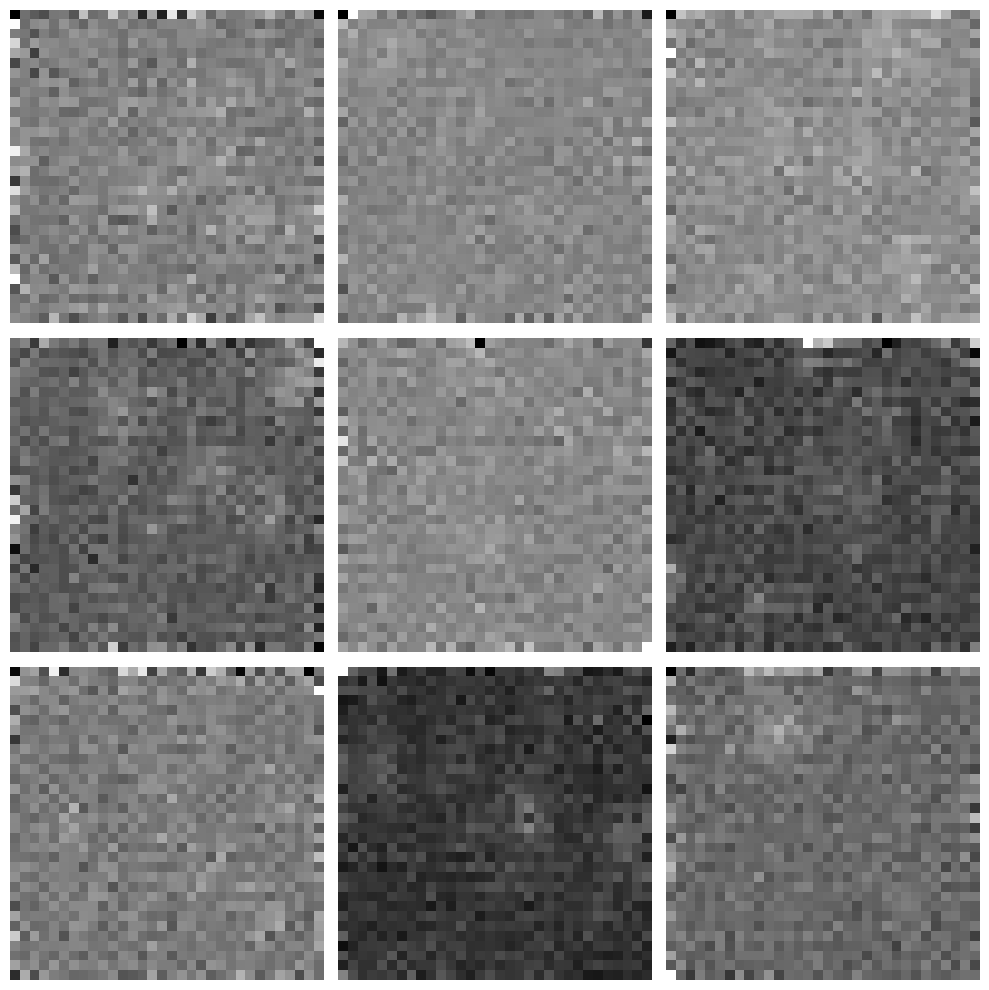


  5%|▌         | 1/20 [01:56<36:50, 116.35s/it]

Loss: 0.0768185555934906
Loss: 0.07960803806781769
Loss: 0.07640790939331055
Loss: 0.07990188151597977
Loss: 0.08175907284021378
Loss: 0.07806962728500366
Loss: 0.07456885278224945
Loss: 0.07404512166976929
Loss: 0.0708349272608757
Loss: 0.08308981359004974
Loss: 0.07940607517957687
Loss: 0.07906557619571686
Loss: 0.07101267576217651
Loss: 0.06365994364023209
Loss: 0.0754239559173584
Loss: 0.06762014329433441
Loss: 0.07944723963737488
Loss: 0.08188861608505249
Loss: 0.08221553266048431
Loss: 0.08226791769266129
Loss: 0.082654669880867
Loss: 0.0700962096452713
Loss: 0.07723534107208252
Loss: 0.07691507041454315
Loss: 0.07013647258281708
Loss: 0.0837455540895462
Loss: 0.06973585486412048
Loss: 0.07816478610038757
Loss: 0.0840294137597084
Loss: 0.07350538671016693
Loss: 0.07225857675075531
Loss: 0.06969016790390015
Loss: 0.06898941844701767
Loss: 0.0706607848405838
Loss: 0.07196691632270813
Loss: 0.08005113899707794
Loss: 0.06438766419887543
Loss: 0.0741381049156189
Loss: 0.07610584795475


100%|█████████▉| 997/1000 [00:19<00:00, 52.20it/s]

Showing/saving samples from epoch 1


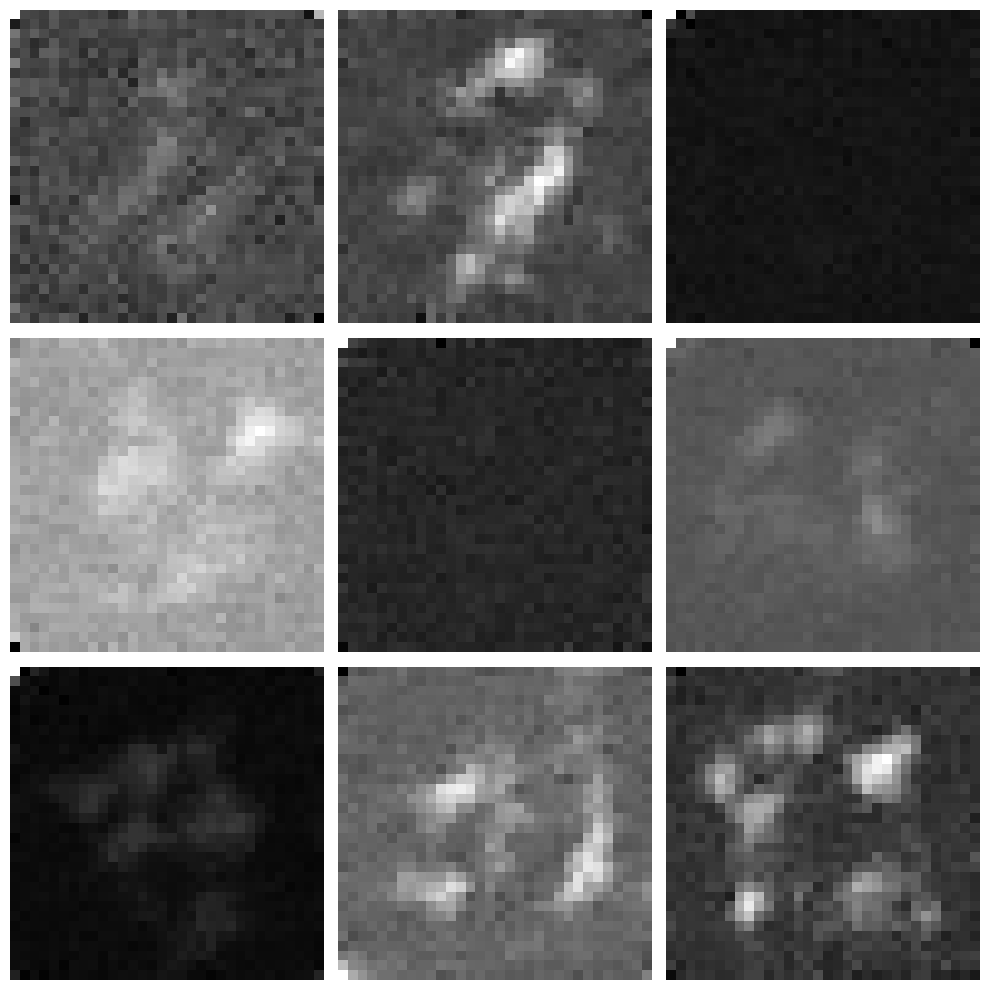

 10%|█         | 2/20 [03:50<34:30, 115.03s/it]

Loss: 0.04726758599281311
Loss: 0.04842483997344971
Loss: 0.048265520483255386
Loss: 0.054473936557769775
Loss: 0.039497680962085724
Loss: 0.04078754782676697
Loss: 0.04931790381669998
Loss: 0.046561144292354584
Loss: 0.050672128796577454
Loss: 0.04089520871639252
Loss: 0.05824524164199829
Loss: 0.046766042709350586
Loss: 0.039368823170661926
Loss: 0.04839037358760834
Loss: 0.05357580631971359
Loss: 0.04835294187068939
Loss: 0.053357113152742386
Loss: 0.04192858934402466
Loss: 0.04543185979127884
Loss: 0.050588786602020264
Loss: 0.05435449630022049
Loss: 0.04809802770614624
Loss: 0.044241420924663544
Loss: 0.04249623417854309
Loss: 0.04951539263129234
Loss: 0.042992230504751205
Loss: 0.04204118251800537
Loss: 0.04271138086915016
Loss: 0.04704786837100983
Loss: 0.049644313752651215
Loss: 0.043420419096946716
Loss: 0.0443837009370327
Loss: 0.043771032243967056
Loss: 0.04550432041287422
Loss: 0.040419138967990875
Loss: 0.043041422963142395
Loss: 0.04429246485233307
Loss: 0.046657089143991


100%|█████████▉| 998/1000 [00:19<00:00, 51.41it/s]

Showing/saving samples from epoch 2


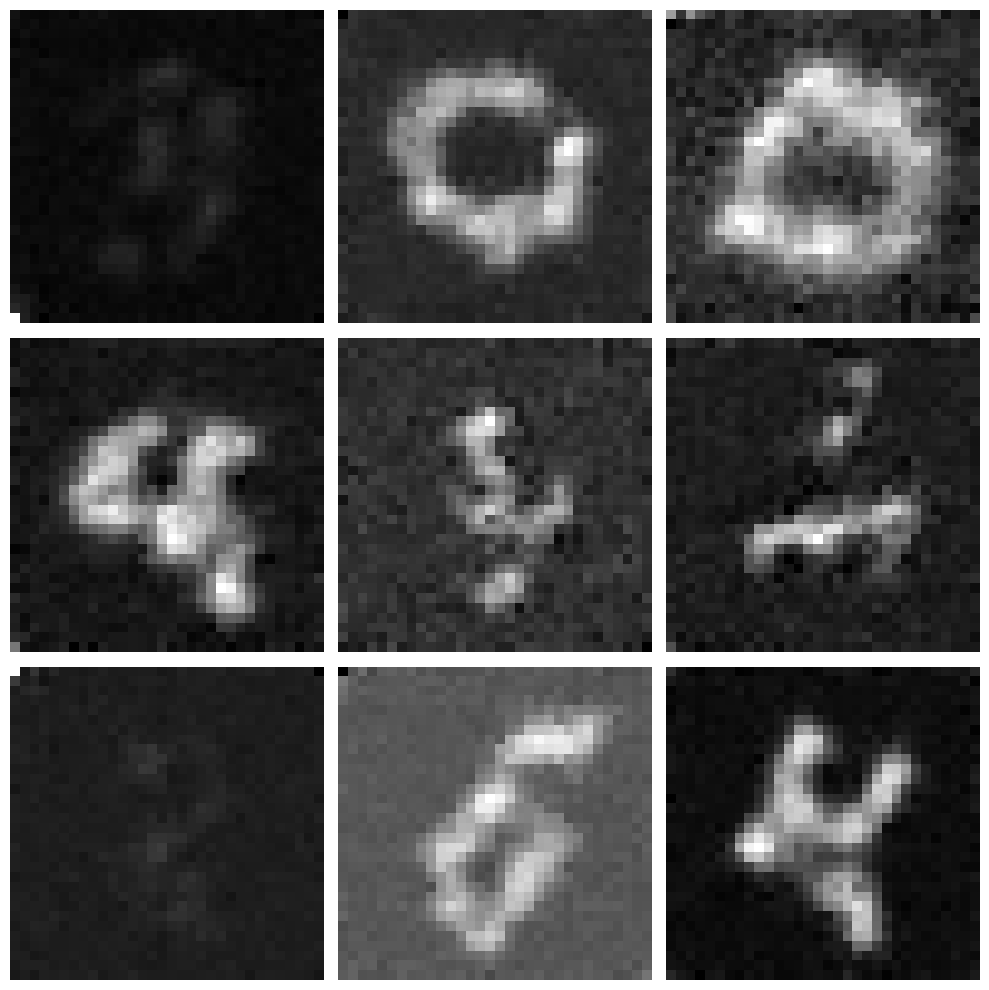

 15%|█▌        | 3/20 [05:44<32:30, 114.76s/it]

Loss: 0.036306094378232956
Loss: 0.034631870687007904
Loss: 0.03826356306672096
Loss: 0.03315877541899681
Loss: 0.031169790774583817
Loss: 0.03429895266890526
Loss: 0.035284653306007385
Loss: 0.036053113639354706
Loss: 0.03864295035600662
Loss: 0.047308869659900665
Loss: 0.03660588711500168
Loss: 0.03757582604885101
Loss: 0.035444896668195724
Loss: 0.04114610701799393
Loss: 0.035614244639873505
Loss: 0.03928428143262863
Loss: 0.03541732579469681
Loss: 0.03362419456243515
Loss: 0.03629570081830025
Loss: 0.03711530566215515
Loss: 0.03177429735660553
Loss: 0.032109349966049194
Loss: 0.03815840929746628
Loss: 0.03791498392820358
Loss: 0.03958285227417946
Loss: 0.031014222651720047
Loss: 0.0324690155684948
Loss: 0.03908189386129379
Loss: 0.03291241452097893
Loss: 0.03255268931388855
Loss: 0.03997350484132767
Loss: 0.027062220498919487
Loss: 0.028177063912153244
Loss: 0.036183618009090424
Loss: 0.035670049488544464
Loss: 0.03387463465332985
Loss: 0.03814612701535225
Loss: 0.03923831880092621


100%|█████████▉| 997/1000 [00:19<00:00, 51.47it/s]

Showing/saving samples from epoch 3


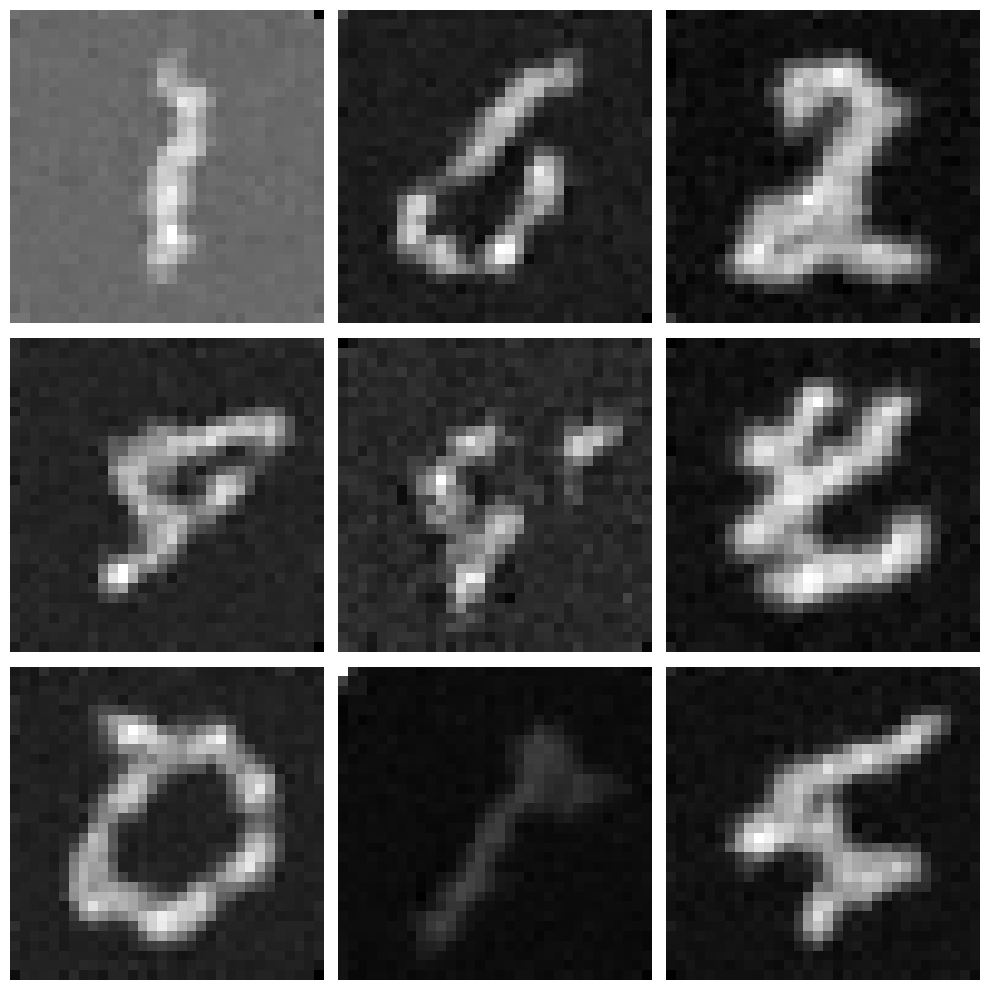

 20%|██        | 4/20 [07:39<30:34, 114.64s/it]

Loss: 0.03036133013665676
Loss: 0.0373389907181263
Loss: 0.02945469506084919
Loss: 0.02809348702430725
Loss: 0.03162018209695816
Loss: 0.026131045073270798
Loss: 0.033647213131189346
Loss: 0.029569797217845917
Loss: 0.02928534708917141
Loss: 0.03702175244688988
Loss: 0.03053050860762596
Loss: 0.029491644352674484
Loss: 0.029651230201125145
Loss: 0.03787803649902344
Loss: 0.029542729258537292
Loss: 0.026791905984282494
Loss: 0.029130375012755394
Loss: 0.030160468071699142
Loss: 0.03525017201900482
Loss: 0.025145642459392548
Loss: 0.031254056841135025
Loss: 0.026210086420178413
Loss: 0.03196777403354645
Loss: 0.03116516023874283
Loss: 0.026962250471115112
Loss: 0.033230192959308624
Loss: 0.029798859730362892
Loss: 0.027766983956098557
Loss: 0.025424668565392494
Loss: 0.030037259683012962
Loss: 0.03177151456475258
Loss: 0.03241197392344475
Loss: 0.03125813975930214
Loss: 0.02880850061774254
Loss: 0.03227062523365021
Loss: 0.031166985630989075
Loss: 0.02871665731072426
Loss: 0.030290298163


100%|█████████▉| 998/1000 [00:19<00:00, 51.69it/s]

Showing/saving samples from epoch 4


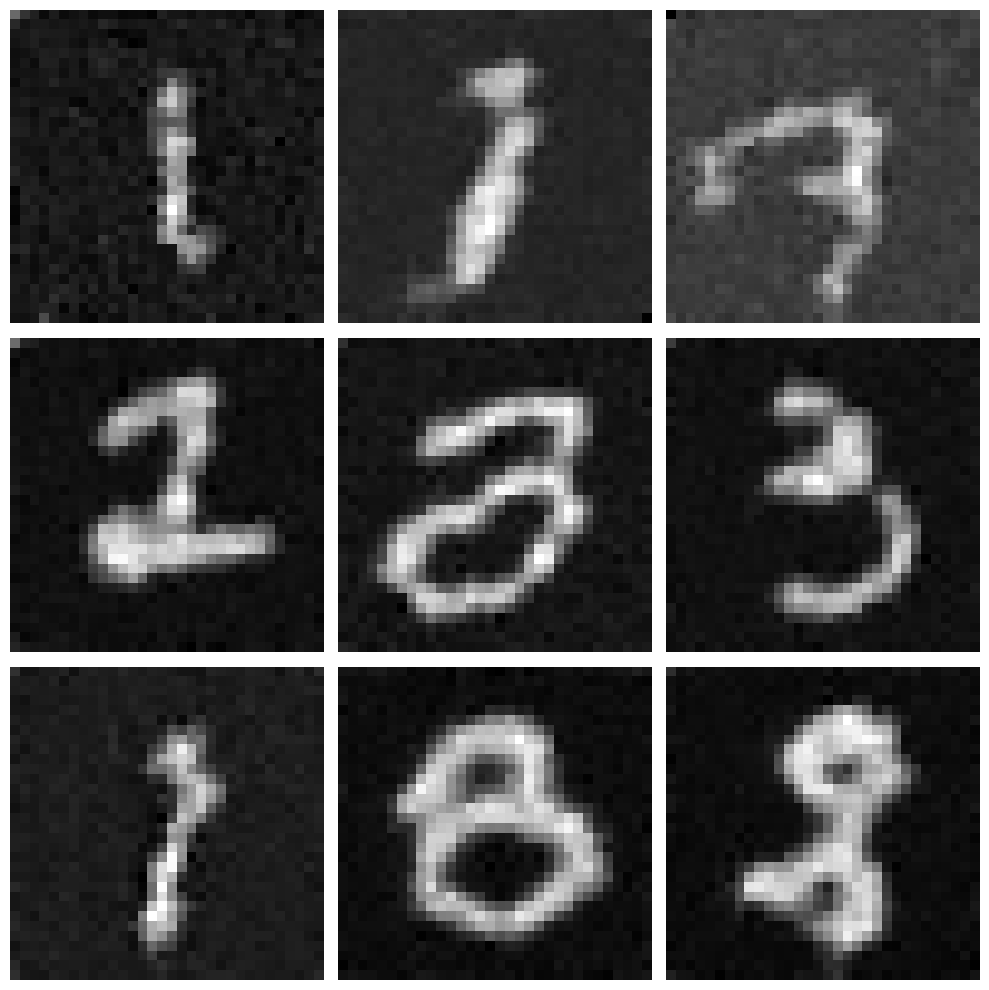

 25%|██▌       | 5/20 [09:33<28:39, 114.61s/it]

Loss: 0.026307469233870506
Loss: 0.024666178971529007
Loss: 0.03198806196451187
Loss: 0.023607224225997925
Loss: 0.032874852418899536
Loss: 0.02482764795422554
Loss: 0.023364130407571793
Loss: 0.030035771429538727
Loss: 0.024268824607133865
Loss: 0.02692514657974243
Loss: 0.023051338270306587
Loss: 0.029419317841529846
Loss: 0.02593652717769146
Loss: 0.0265970341861248
Loss: 0.026182373985648155
Loss: 0.023618200793862343
Loss: 0.03182428330183029
Loss: 0.030129650607705116
Loss: 0.02757759764790535
Loss: 0.024218900129199028
Loss: 0.027684155851602554
Loss: 0.02558038756251335
Loss: 0.029051128774881363
Loss: 0.02487557753920555
Loss: 0.0237533338367939
Loss: 0.02655204012989998
Loss: 0.024855637922883034
Loss: 0.026330284774303436
Loss: 0.02655857801437378
Loss: 0.022945106029510498
Loss: 0.02675950527191162
Loss: 0.030460871756076813
Loss: 0.028395947068929672
Loss: 0.03032604232430458
Loss: 0.025967691093683243
Loss: 0.025906043127179146
Loss: 0.025396719574928284
Loss: 0.031087644


100%|█████████▉| 998/1000 [00:19<00:00, 54.06it/s]

Showing/saving samples from epoch 5


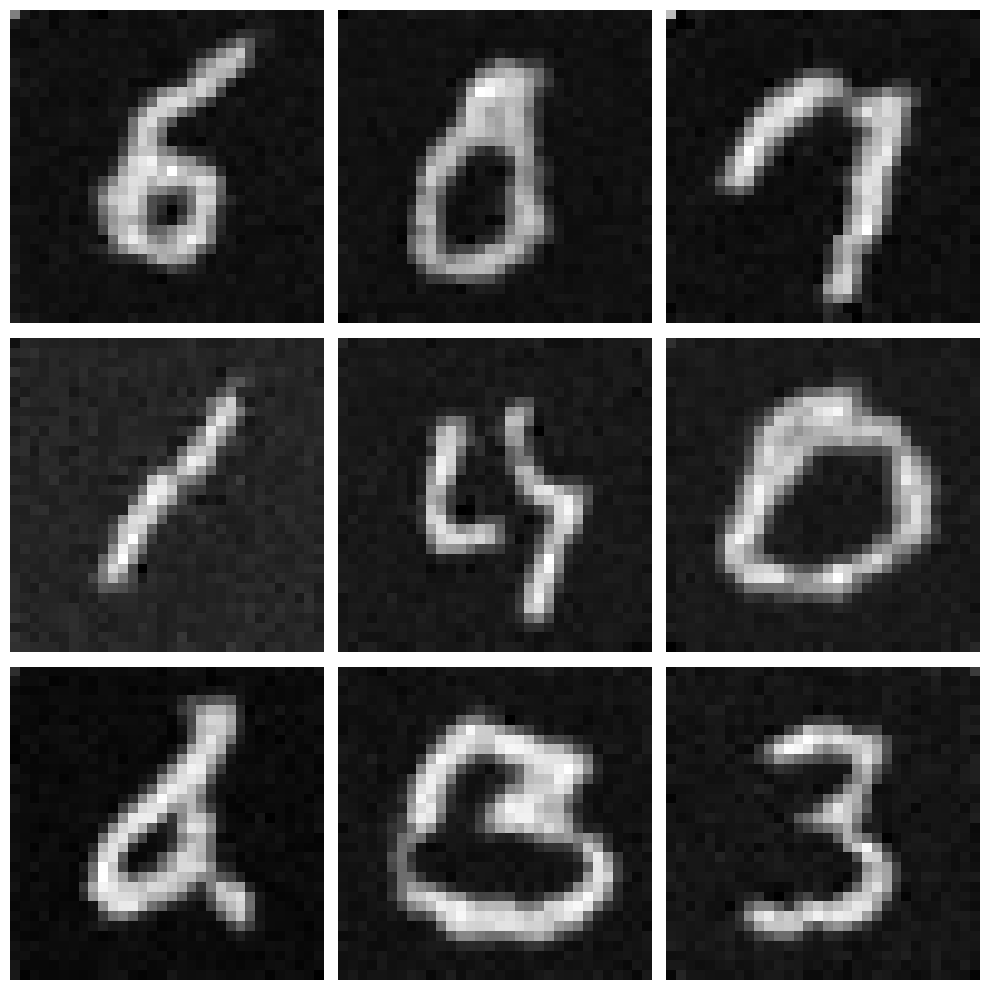

 30%|███       | 6/20 [11:28<26:43, 114.52s/it]

Loss: 0.02543233521282673
Loss: 0.0225595124065876
Loss: 0.02700616419315338
Loss: 0.023453690111637115
Loss: 0.025363491848111153
Loss: 0.02481743134558201
Loss: 0.020431730896234512
Loss: 0.026639753952622414
Loss: 0.027308223769068718
Loss: 0.026875432580709457
Loss: 0.024768847972154617
Loss: 0.023905443027615547
Loss: 0.02419809252023697
Loss: 0.02844887226819992
Loss: 0.024389581754803658
Loss: 0.024018848314881325
Loss: 0.023726914077997208
Loss: 0.021690774708986282
Loss: 0.024527132511138916
Loss: 0.022235779091715813
Loss: 0.02167988196015358
Loss: 0.026898790150880814
Loss: 0.022275857627391815
Loss: 0.020756302401423454
Loss: 0.021292787045240402
Loss: 0.022145751863718033
Loss: 0.022630952298641205
Loss: 0.02524114027619362
Loss: 0.025815628468990326
Loss: 0.020425569266080856
Loss: 0.02249010279774666
Loss: 0.021799474954605103
Loss: 0.022877879440784454
Loss: 0.026603423058986664
Loss: 0.024699009954929352
Loss: 0.02544347196817398
Loss: 0.024200616404414177
Loss: 0.0238


100%|█████████▉| 997/1000 [00:19<00:00, 52.52it/s]

Showing/saving samples from epoch 6


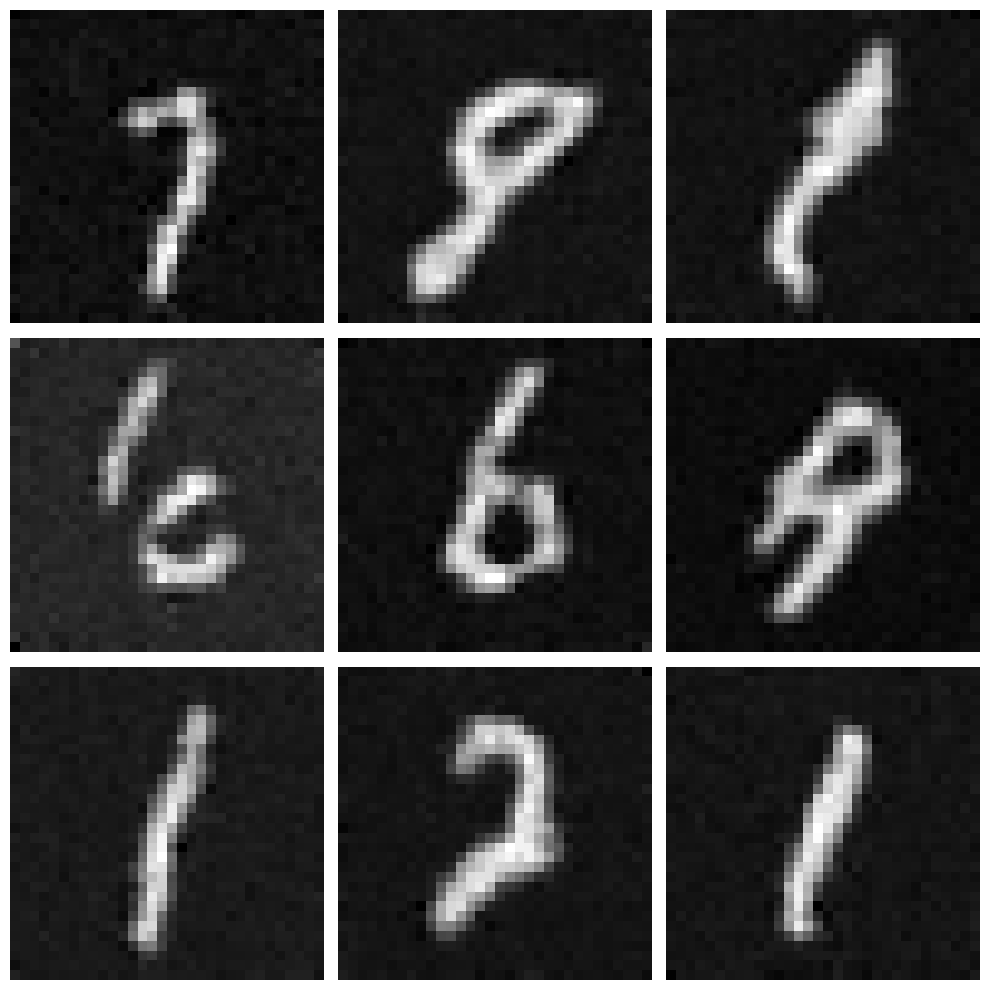

 35%|███▌      | 7/20 [13:22<24:48, 114.49s/it]

Loss: 0.02098347246646881
Loss: 0.02032465487718582
Loss: 0.02247767336666584
Loss: 0.021838057786226273
Loss: 0.023849811404943466
Loss: 0.02310691773891449
Loss: 0.020702868700027466
Loss: 0.026013929396867752
Loss: 0.01986854523420334
Loss: 0.01640305481851101
Loss: 0.022465629503130913
Loss: 0.023057740181684494
Loss: 0.025054456666111946
Loss: 0.022129449993371964
Loss: 0.022204294800758362
Loss: 0.024525899440050125
Loss: 0.023335374891757965
Loss: 0.023373953998088837
Loss: 0.02385532669723034
Loss: 0.02137540467083454
Loss: 0.023689836263656616
Loss: 0.021925315260887146
Loss: 0.01878427155315876
Loss: 0.019748929888010025
Loss: 0.018323637545108795
Loss: 0.021896421909332275
Loss: 0.021380402147769928
Loss: 0.025757605209946632
Loss: 0.01804143190383911
Loss: 0.018406376242637634
Loss: 0.02448973059654236
Loss: 0.024298306554555893
Loss: 0.028620649129152298
Loss: 0.029237838461995125
Loss: 0.018590476363897324
Loss: 0.023141484707593918
Loss: 0.021200180053710938
Loss: 0.0228


100%|█████████▉| 999/1000 [00:19<00:00, 51.57it/s]

Showing/saving samples from epoch 7


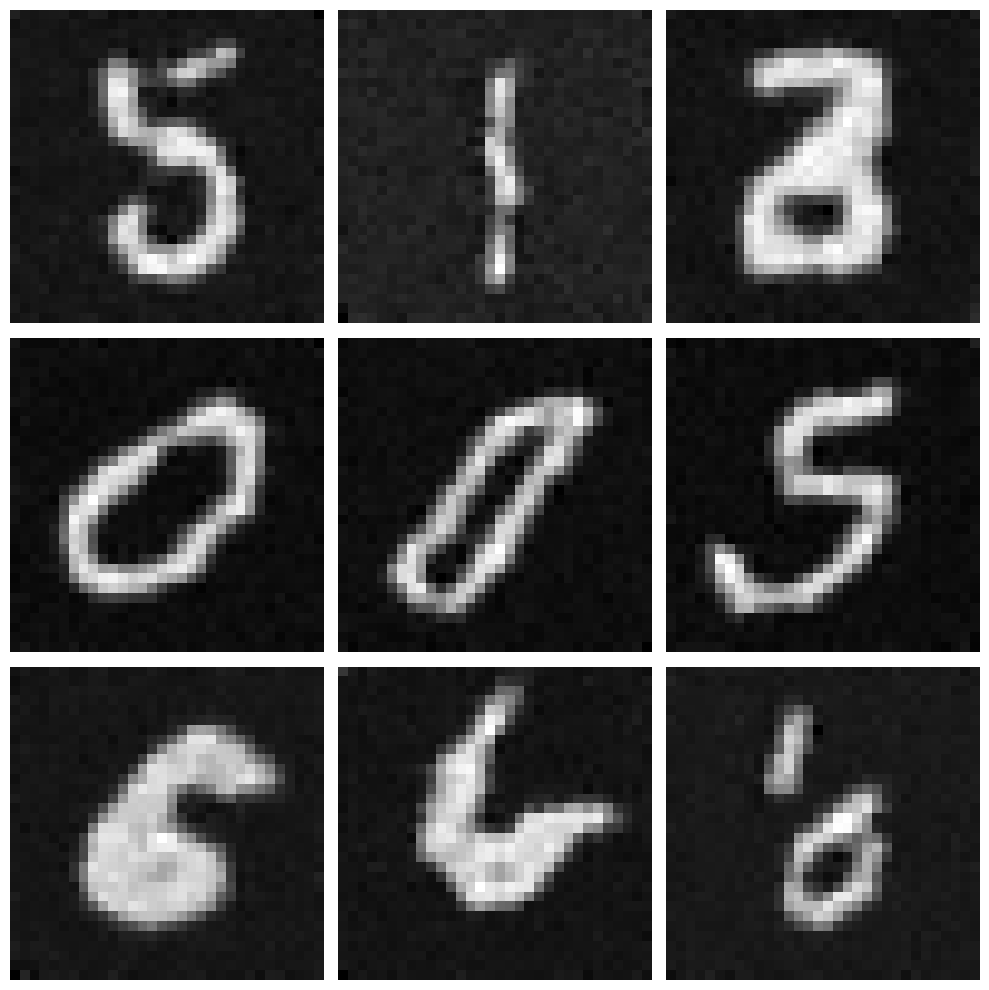

 40%|████      | 8/20 [15:17<22:54, 114.53s/it]

Loss: 0.020957954227924347
Loss: 0.023039154708385468
Loss: 0.018613256514072418
Loss: 0.021811481565237045
Loss: 0.018598277121782303
Loss: 0.02020893432199955
Loss: 0.018344823271036148
Loss: 0.021160397678613663
Loss: 0.023489613085985184
Loss: 0.019046731293201447
Loss: 0.018428396433591843
Loss: 0.022994382306933403
Loss: 0.020194321870803833
Loss: 0.022516336292028427
Loss: 0.0204111710190773
Loss: 0.019046977162361145
Loss: 0.02187291905283928
Loss: 0.01883183978497982
Loss: 0.017765773460268974
Loss: 0.02306356281042099
Loss: 0.022703589871525764
Loss: 0.02024633064866066
Loss: 0.021910466253757477
Loss: 0.021578647196292877
Loss: 0.018716849386692047
Loss: 0.022266989573836327
Loss: 0.02326417714357376
Loss: 0.017126061022281647
Loss: 0.018647249788045883
Loss: 0.023030173033475876
Loss: 0.020643968135118484
Loss: 0.02495097741484642
Loss: 0.023655634373426437
Loss: 0.017895076423883438
Loss: 0.019766127690672874
Loss: 0.02139408141374588
Loss: 0.01862279698252678
Loss: 0.0276


100%|█████████▉| 998/1000 [00:19<00:00, 53.33it/s]

Showing/saving samples from epoch 8


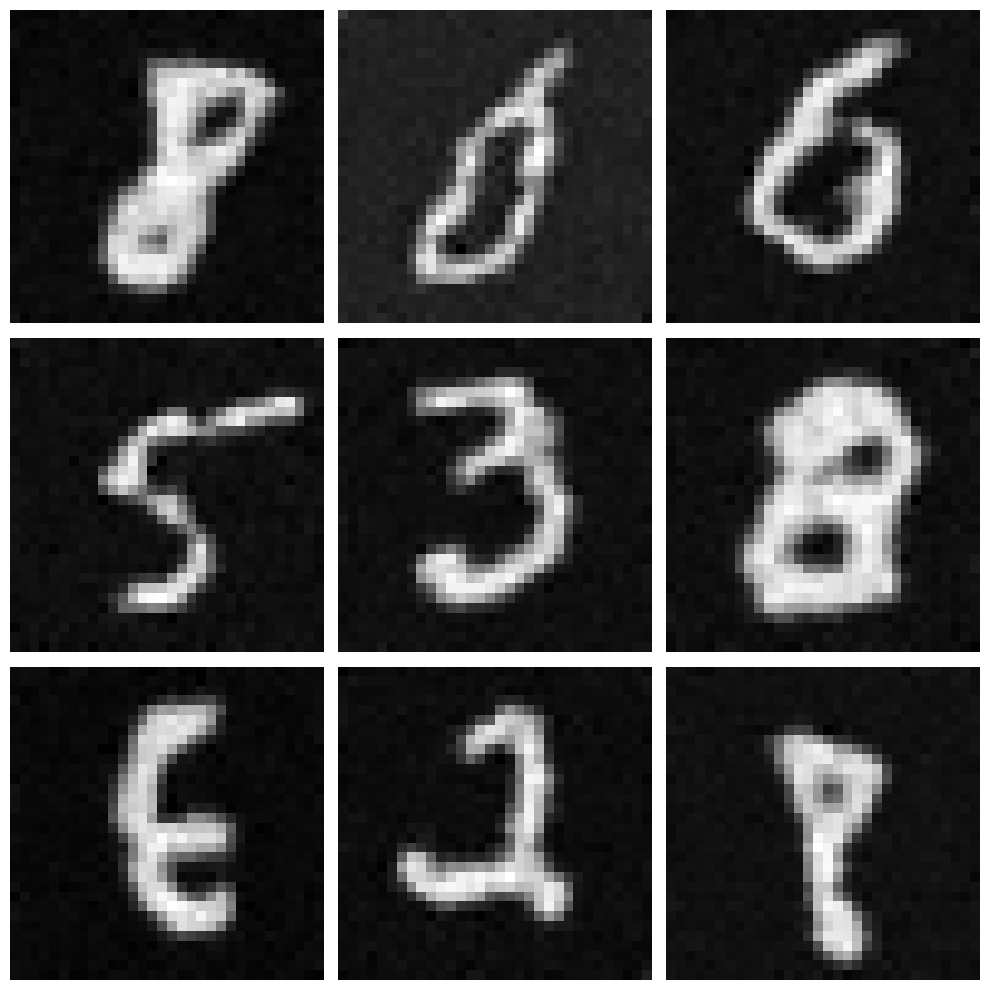

 45%|████▌     | 9/20 [17:11<20:59, 114.48s/it]

Loss: 0.02036086469888687
Loss: 0.022275403141975403
Loss: 0.01808967813849449
Loss: 0.018616236746311188
Loss: 0.022367365658283234
Loss: 0.021535731852054596
Loss: 0.024706806987524033
Loss: 0.021369878202676773
Loss: 0.020969446748495102
Loss: 0.016913985833525658
Loss: 0.02084846794605255
Loss: 0.017666449770331383
Loss: 0.017218349501490593
Loss: 0.02094998210668564
Loss: 0.019003210589289665
Loss: 0.021186361089348793
Loss: 0.020679455250501633
Loss: 0.01953284814953804
Loss: 0.017437290400266647
Loss: 0.020604968070983887
Loss: 0.0187351256608963
Loss: 0.020383063703775406
Loss: 0.020052965730428696
Loss: 0.016733065247535706
Loss: 0.01699789986014366
Loss: 0.018765486776828766
Loss: 0.020574767142534256
Loss: 0.01571057364344597
Loss: 0.02416997216641903
Loss: 0.01896541379392147
Loss: 0.02152973785996437
Loss: 0.01906689628958702
Loss: 0.02006705477833748
Loss: 0.01990070939064026
Loss: 0.023542875424027443
Loss: 0.019785091280937195
Loss: 0.01814865507185459
Loss: 0.019667183


100%|█████████▉| 998/1000 [00:19<00:00, 49.34it/s]

Showing/saving samples from epoch 9


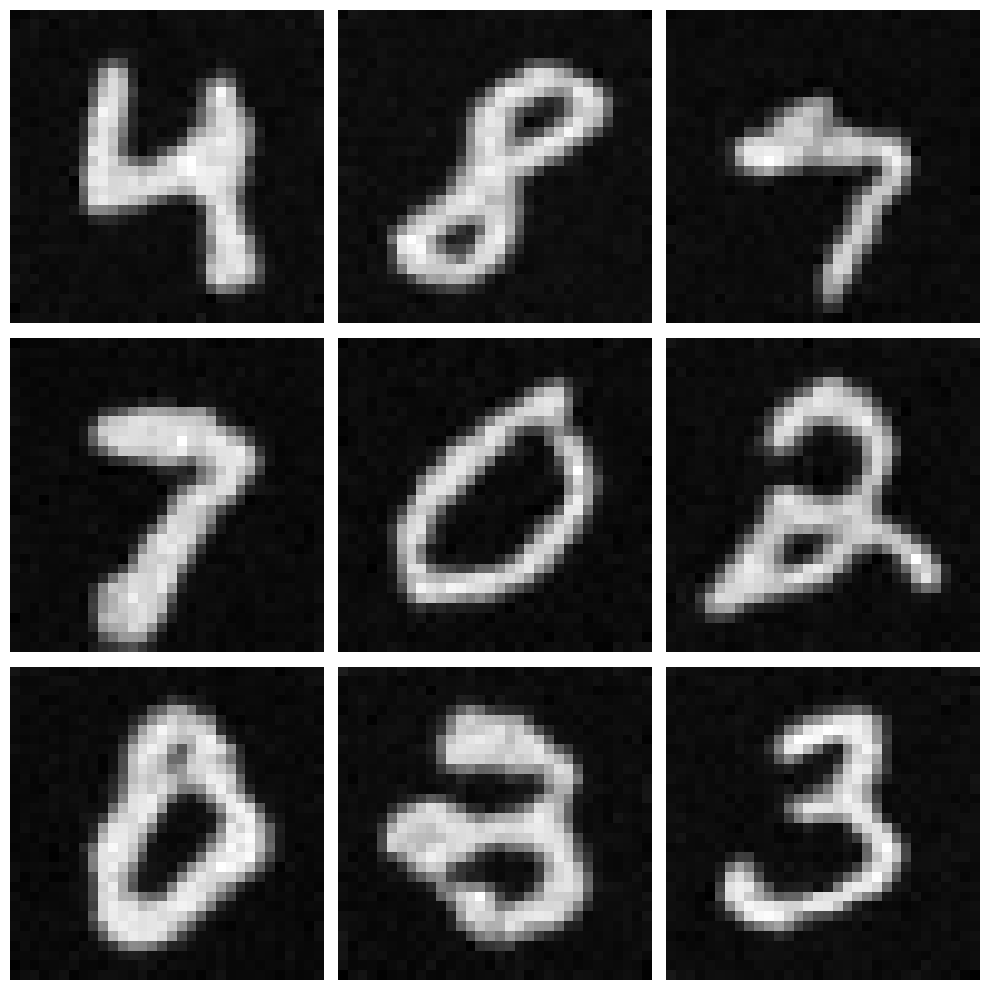

 50%|█████     | 10/20 [19:05<19:04, 114.42s/it]

Loss: 0.01841883175075054
Loss: 0.01997160166501999
Loss: 0.020062094554305077
Loss: 0.01582835055887699
Loss: 0.01784372702240944
Loss: 0.01770784519612789
Loss: 0.0181979238986969
Loss: 0.018829956650733948
Loss: 0.01806403137743473
Loss: 0.0166789423674345
Loss: 0.018288638442754745
Loss: 0.020712081342935562
Loss: 0.017447829246520996
Loss: 0.01933230459690094
Loss: 0.016465013846755028
Loss: 0.017533186823129654
Loss: 0.01600884087383747
Loss: 0.017542123794555664
Loss: 0.01814180612564087
Loss: 0.01799646019935608
Loss: 0.021150441840291023
Loss: 0.0187632255256176
Loss: 0.016774218529462814
Loss: 0.025660136714577675
Loss: 0.021114718168973923
Loss: 0.017413198947906494
Loss: 0.02074943482875824
Loss: 0.019306212663650513
Loss: 0.018332455307245255
Loss: 0.021042874082922935
Loss: 0.019985411316156387
Loss: 0.01996787078678608
Loss: 0.017364123836159706
Loss: 0.015564481727778912
Loss: 0.015109751373529434
Loss: 0.016811762005090714
Loss: 0.018183674663305283
Loss: 0.01954682916


100%|█████████▉| 995/1000 [00:19<00:00, 51.45it/s]

Showing/saving samples from epoch 10


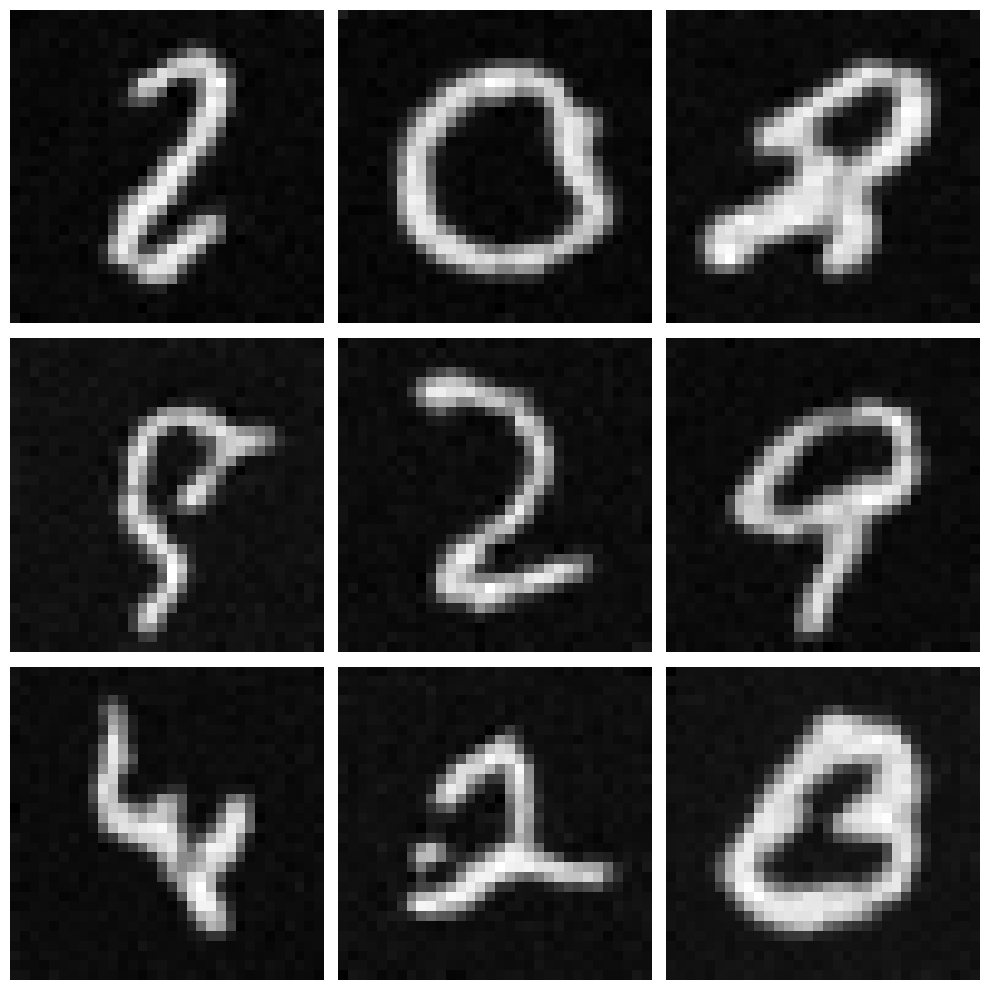

 55%|█████▌    | 11/20 [21:00<17:09, 114.43s/it]

Loss: 0.016860872507095337
Loss: 0.02018611878156662
Loss: 0.018488595262169838
Loss: 0.01806551404297352
Loss: 0.01377694308757782
Loss: 0.013825492933392525
Loss: 0.021618152037262917
Loss: 0.015169240534305573
Loss: 0.01984155736863613
Loss: 0.0154862180352211
Loss: 0.01777493581175804
Loss: 0.017856311053037643
Loss: 0.017944402992725372
Loss: 0.016397811472415924
Loss: 0.019923530519008636
Loss: 0.01739998534321785
Loss: 0.01826975867152214
Loss: 0.017632368952035904
Loss: 0.017307259142398834
Loss: 0.021376997232437134
Loss: 0.0158267542719841
Loss: 0.013275319710373878
Loss: 0.01747521013021469
Loss: 0.020497769117355347
Loss: 0.015417507849633694
Loss: 0.016939755529165268
Loss: 0.015316871926188469
Loss: 0.016329407691955566
Loss: 0.01876923441886902
Loss: 0.018056008964776993
Loss: 0.017593294382095337
Loss: 0.01717209815979004
Loss: 0.01736639440059662
Loss: 0.01528933271765709
Loss: 0.01668151468038559
Loss: 0.014348048716783524
Loss: 0.017145048826932907
Loss: 0.0166988186


100%|█████████▉| 998/1000 [00:19<00:00, 46.88it/s]

Showing/saving samples from epoch 11


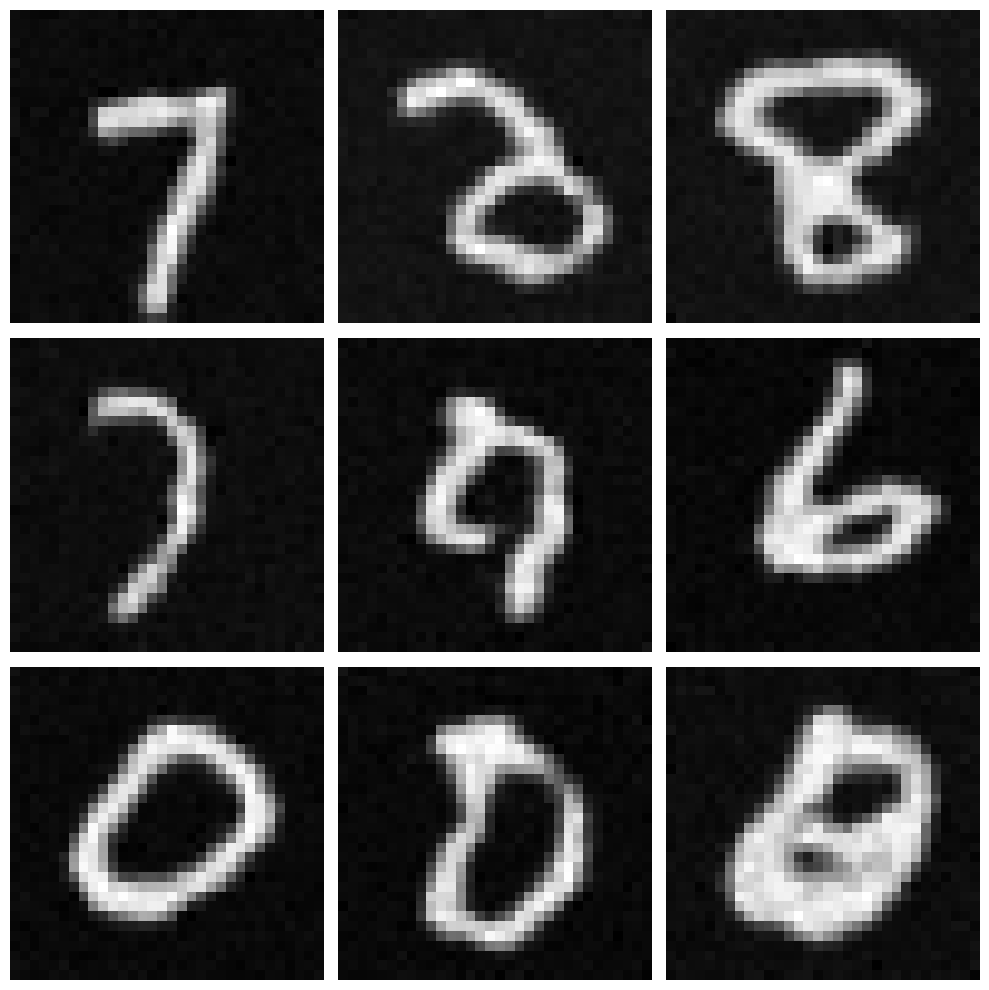

 60%|██████    | 12/20 [22:54<15:15, 114.45s/it]

Loss: 0.015356793999671936
Loss: 0.015989268198609352
Loss: 0.01724214106798172
Loss: 0.018431004136800766
Loss: 0.015314347110688686
Loss: 0.019518164917826653
Loss: 0.01767280511558056
Loss: 0.014669193886220455
Loss: 0.013815128244459629
Loss: 0.019795875996351242
Loss: 0.02047903835773468
Loss: 0.0189204104244709
Loss: 0.016750594601035118
Loss: 0.016780469566583633
Loss: 0.01855303905904293
Loss: 0.01911100745201111
Loss: 0.01660582795739174
Loss: 0.015771787613630295
Loss: 0.01629629358649254
Loss: 0.021282460540533066
Loss: 0.013932759873569012
Loss: 0.01930542290210724
Loss: 0.017731597647070885
Loss: 0.017890917137265205
Loss: 0.015514414757490158
Loss: 0.01664676144719124
Loss: 0.016625352203845978
Loss: 0.023880869150161743
Loss: 0.020376089960336685
Loss: 0.017405357211828232
Loss: 0.01819230616092682
Loss: 0.020026005804538727
Loss: 0.019108619540929794
Loss: 0.016927622258663177
Loss: 0.018577050417661667
Loss: 0.01866806298494339
Loss: 0.015149585902690887
Loss: 0.017781


100%|█████████▉| 995/1000 [00:19<00:00, 50.97it/s]

Showing/saving samples from epoch 12


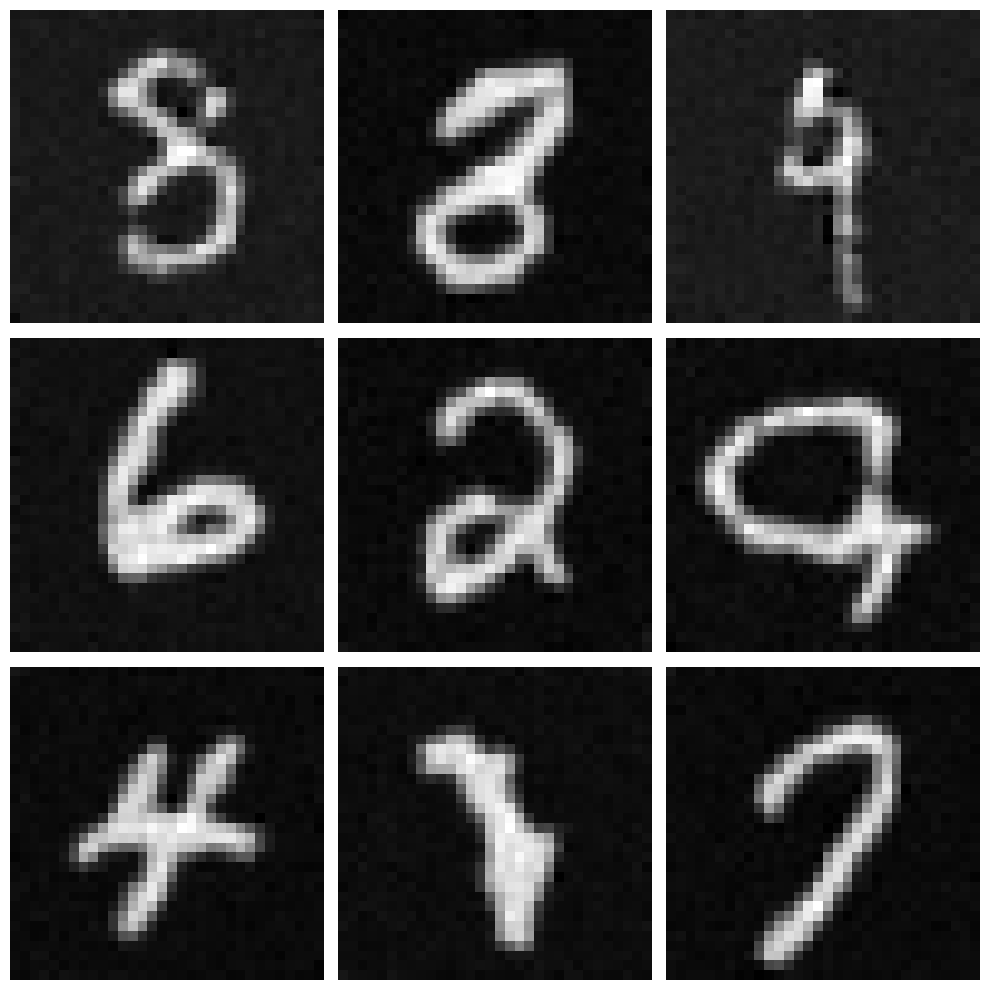

 65%|██████▌   | 13/20 [24:49<13:21, 114.54s/it]

Loss: 0.016823912039399147
Loss: 0.0212680883705616
Loss: 0.020103177055716515
Loss: 0.013946869410574436
Loss: 0.01976931467652321
Loss: 0.013947652652859688
Loss: 0.01733268052339554
Loss: 0.019094806164503098
Loss: 0.01701751910150051
Loss: 0.01616351120173931
Loss: 0.02066444791853428
Loss: 0.016806701198220253
Loss: 0.016771521419286728
Loss: 0.01574523374438286
Loss: 0.014996320009231567
Loss: 0.015414907597005367
Loss: 0.015821969136595726
Loss: 0.015082526952028275
Loss: 0.014677932485938072
Loss: 0.013812176883220673
Loss: 0.015535097569227219
Loss: 0.017697714269161224
Loss: 0.016548819839954376
Loss: 0.016514798626303673
Loss: 0.017124729230999947
Loss: 0.015921149402856827
Loss: 0.016640853136777878
Loss: 0.015687275677919388
Loss: 0.018938429653644562
Loss: 0.020756512880325317
Loss: 0.020344600081443787
Loss: 0.01870126836001873
Loss: 0.01581820473074913
Loss: 0.016629569232463837
Loss: 0.016684655100107193
Loss: 0.015782330185174942
Loss: 0.015573717653751373
Loss: 0.016


100%|█████████▉| 998/1000 [00:19<00:00, 50.18it/s]

Showing/saving samples from epoch 13


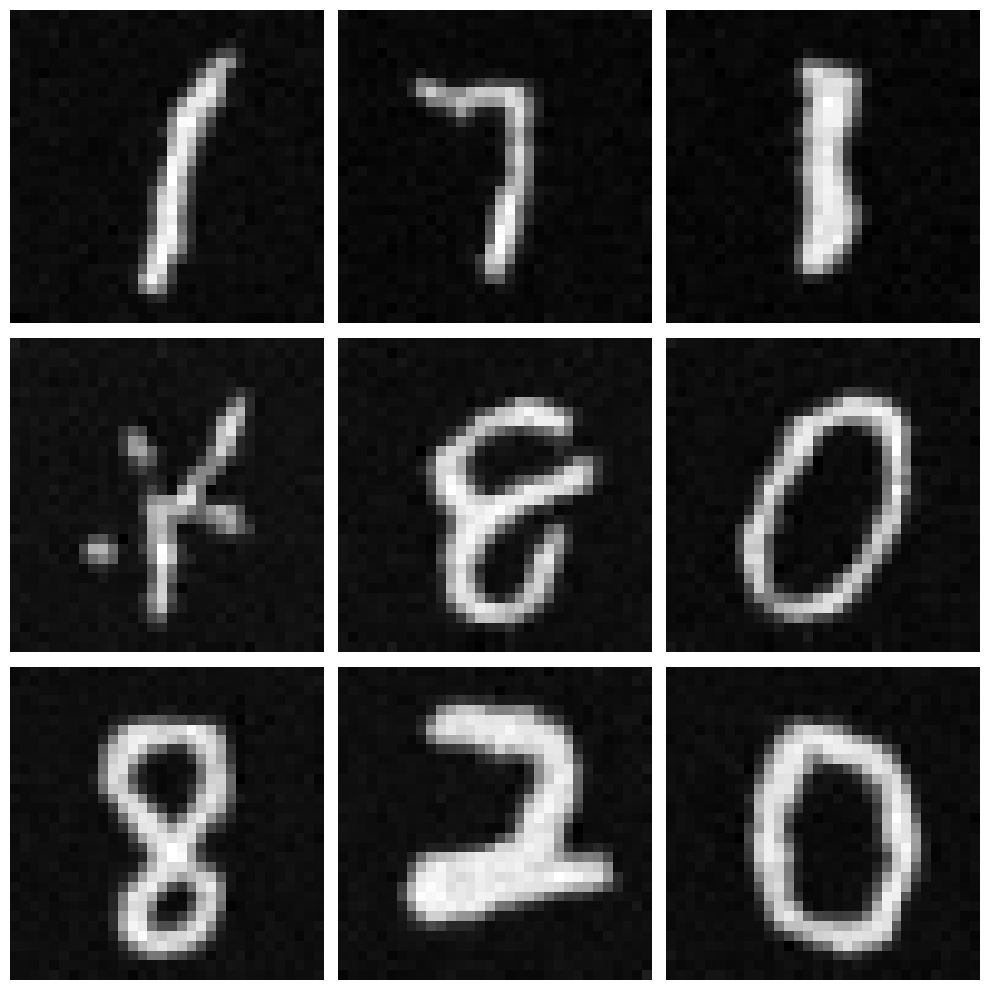

 70%|███████   | 14/20 [26:44<11:27, 114.56s/it]

Loss: 0.01593136414885521
Loss: 0.018442831933498383
Loss: 0.017851870507001877
Loss: 0.017566371709108353
Loss: 0.01577746868133545
Loss: 0.015624888241291046
Loss: 0.02127322554588318
Loss: 0.01394825428724289
Loss: 0.01507476158440113
Loss: 0.01652824878692627
Loss: 0.016045592725276947
Loss: 0.017523597925901413
Loss: 0.020098142325878143
Loss: 0.015619760379195213
Loss: 0.015545045956969261
Loss: 0.014240577816963196
Loss: 0.017852257937192917
Loss: 0.017734883353114128
Loss: 0.015209157951176167
Loss: 0.016907941550016403
Loss: 0.013725296594202518
Loss: 0.01757986471056938
Loss: 0.0167018361389637
Loss: 0.015483146533370018
Loss: 0.01857271045446396
Loss: 0.015024172142148018
Loss: 0.021116942167282104
Loss: 0.014859615825116634
Loss: 0.020153261721134186
Loss: 0.01824907958507538
Loss: 0.015209957025945187
Loss: 0.014505084604024887
Loss: 0.015250996686518192
Loss: 0.01804260164499283
Loss: 0.015008559450507164
Loss: 0.012378689832985401
Loss: 0.016929619014263153
Loss: 0.01504


100%|█████████▉| 996/1000 [00:19<00:00, 52.22it/s]

Showing/saving samples from epoch 14


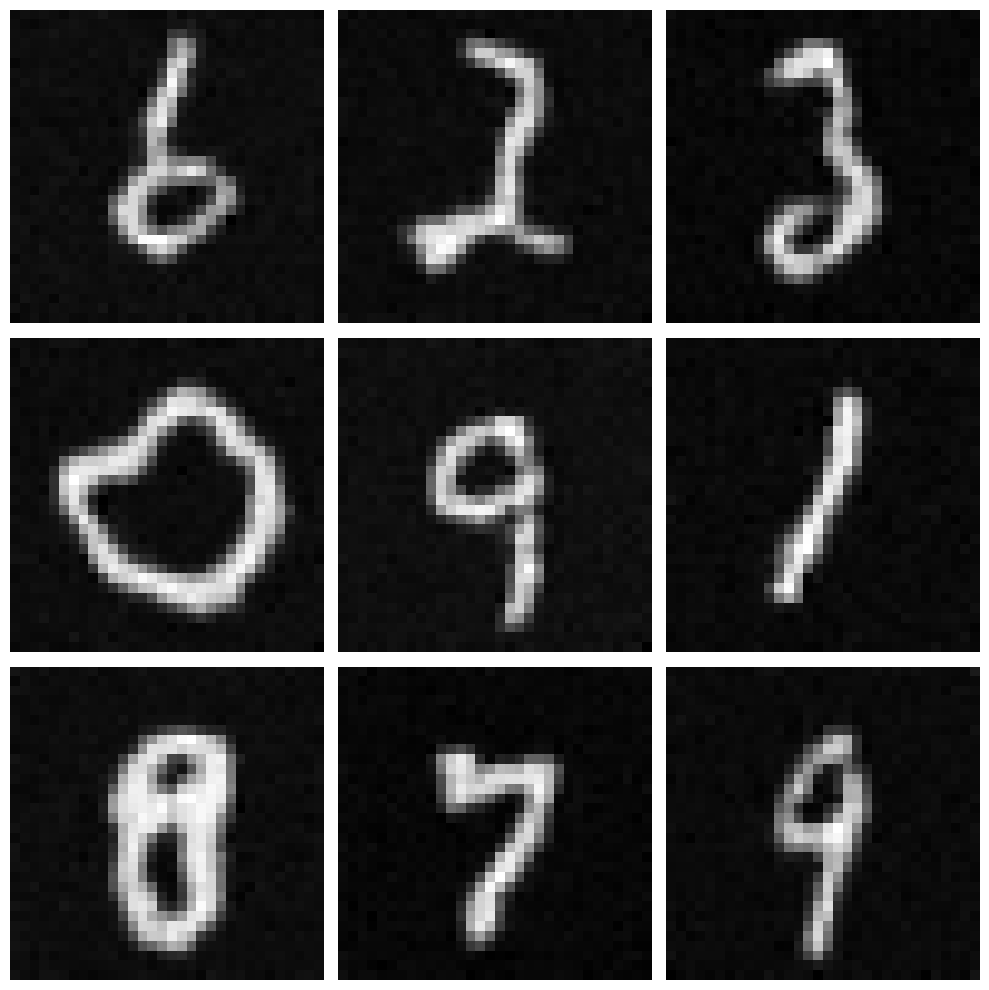

 75%|███████▌  | 15/20 [28:38<09:32, 114.53s/it]

Loss: 0.018089044839143753
Loss: 0.017932403832674026
Loss: 0.01628393493592739
Loss: 0.013972404412925243
Loss: 0.018035724759101868
Loss: 0.014452440664172173
Loss: 0.014363772235810757
Loss: 0.015889950096607208
Loss: 0.01665758714079857
Loss: 0.019111234694719315
Loss: 0.015971023589372635
Loss: 0.016296282410621643
Loss: 0.016499752178788185
Loss: 0.016667190939188004
Loss: 0.014776170253753662
Loss: 0.012953335419297218
Loss: 0.020068887621164322
Loss: 0.017485642805695534
Loss: 0.01238186564296484
Loss: 0.0148136792704463
Loss: 0.016801871359348297
Loss: 0.019568651914596558
Loss: 0.01602219045162201
Loss: 0.015404559671878815
Loss: 0.015796231105923653
Loss: 0.015516657382249832
Loss: 0.01727273128926754
Loss: 0.013649377971887589
Loss: 0.019789060577750206
Loss: 0.01826982945203781
Loss: 0.01596459373831749
Loss: 0.014810970053076744
Loss: 0.016259077936410904
Loss: 0.01594136655330658
Loss: 0.016624815762043
Loss: 0.016090042889118195
Loss: 0.014952687546610832
Loss: 0.018927


100%|█████████▉| 999/1000 [00:19<00:00, 50.33it/s]

Showing/saving samples from epoch 15


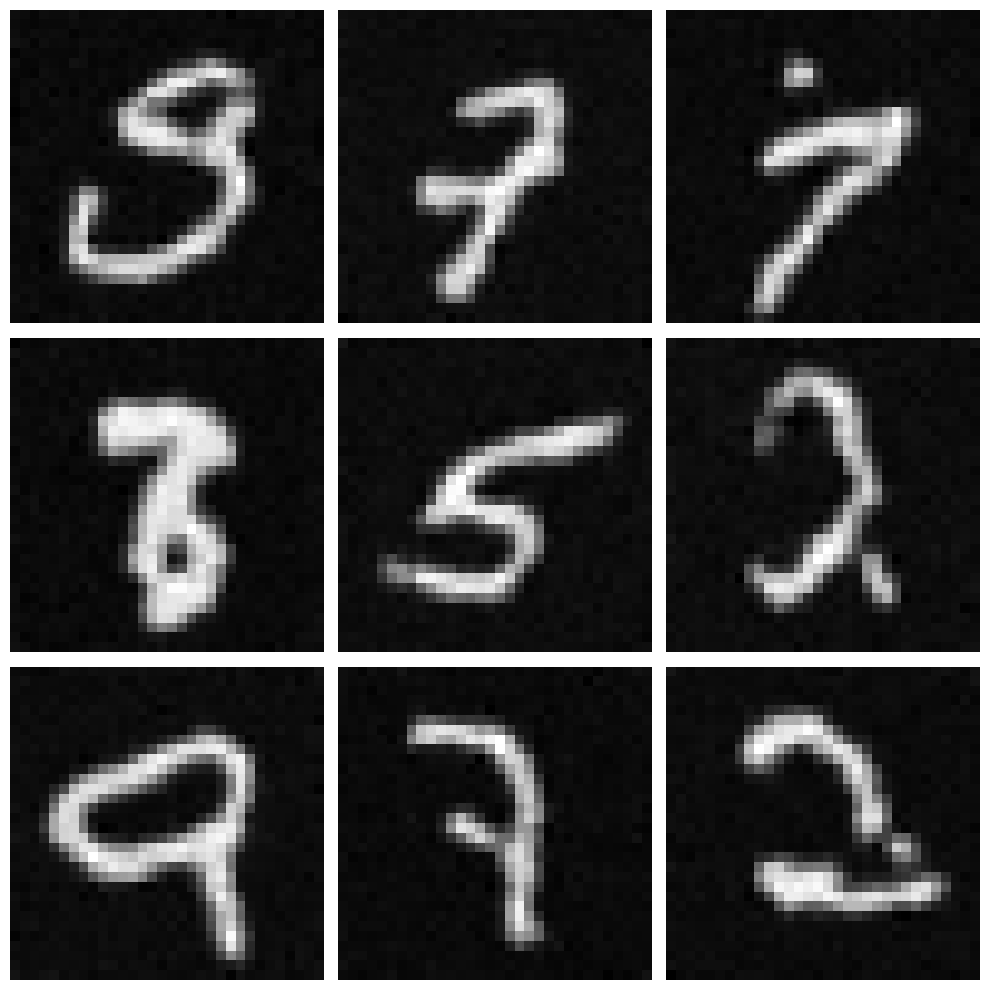

 80%|████████  | 16/20 [30:33<07:38, 114.52s/it]

Loss: 0.017033834010362625
Loss: 0.014656932093203068
Loss: 0.013989529572427273
Loss: 0.01443236880004406
Loss: 0.016369441524147987
Loss: 0.019496727734804153
Loss: 0.0118452999740839
Loss: 0.017403753474354744
Loss: 0.01755836233496666
Loss: 0.01592085510492325
Loss: 0.012950325384736061
Loss: 0.01623769849538803
Loss: 0.015094606205821037
Loss: 0.011789137497544289
Loss: 0.017310069873929024
Loss: 0.01699918508529663
Loss: 0.013357285410165787
Loss: 0.015355954878032207
Loss: 0.020334018394351006
Loss: 0.01365482248365879
Loss: 0.01428207941353321
Loss: 0.017533790320158005
Loss: 0.016407044604420662
Loss: 0.019180648028850555
Loss: 0.016536731272935867
Loss: 0.019831214100122452
Loss: 0.016536928713321686
Loss: 0.01632346585392952
Loss: 0.0169064998626709
Loss: 0.018142126500606537
Loss: 0.018983369693160057
Loss: 0.01424571592360735
Loss: 0.019832324236631393
Loss: 0.017221461981534958
Loss: 0.014723345637321472
Loss: 0.016416354104876518
Loss: 0.016535595059394836
Loss: 0.017785


100%|█████████▉| 999/1000 [00:19<00:00, 52.19it/s]

Showing/saving samples from epoch 16


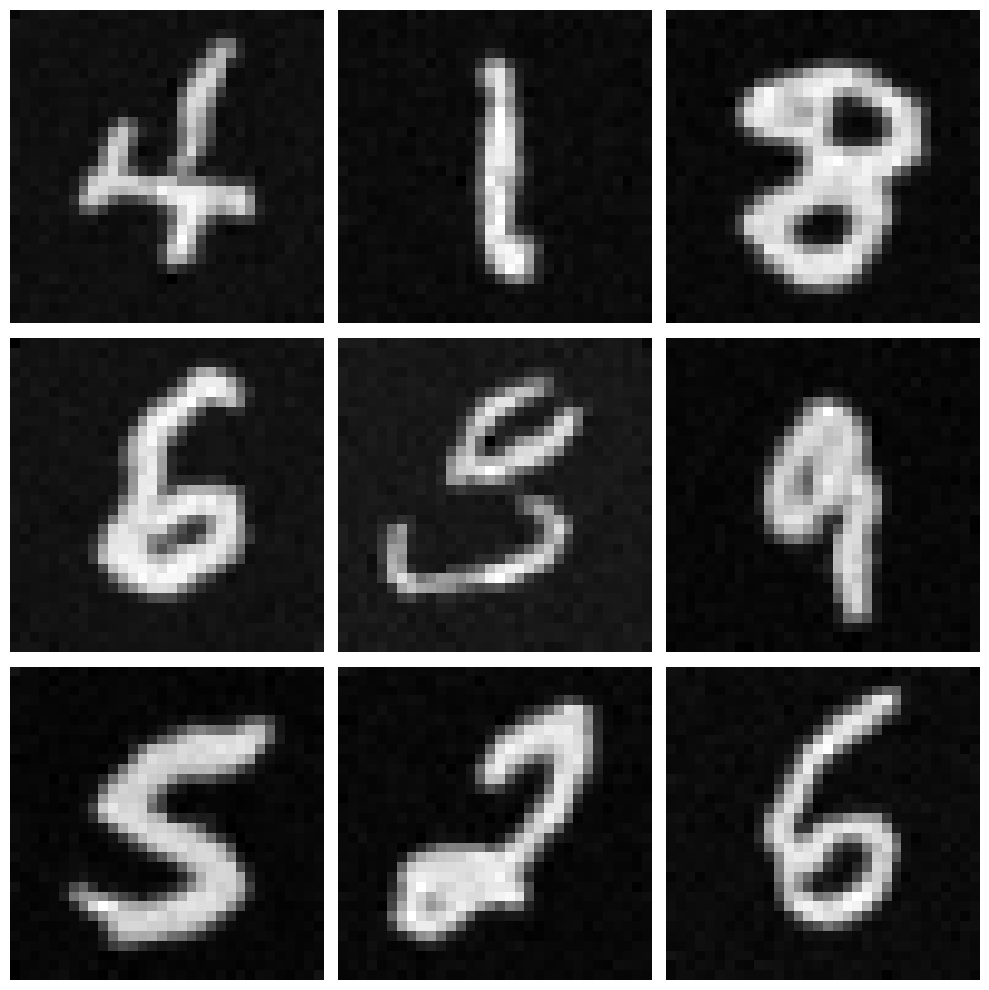

 85%|████████▌ | 17/20 [32:27<05:43, 114.57s/it]

Loss: 0.015020506456494331
Loss: 0.014860954135656357
Loss: 0.018396880477666855
Loss: 0.012762313708662987
Loss: 0.014836328104138374
Loss: 0.01375906728208065
Loss: 0.01568720117211342
Loss: 0.014631981961429119
Loss: 0.01343568041920662
Loss: 0.014156131073832512
Loss: 0.015999935567378998
Loss: 0.01504550687968731
Loss: 0.01378354150801897
Loss: 0.015649007633328438
Loss: 0.01353931613266468
Loss: 0.015824617817997932
Loss: 0.01681387796998024
Loss: 0.015133331529796124
Loss: 0.014978823252022266
Loss: 0.01631002128124237
Loss: 0.015073712915182114
Loss: 0.013115940615534782
Loss: 0.013230299577116966
Loss: 0.01720246858894825
Loss: 0.014651721343398094
Loss: 0.015637433156371117
Loss: 0.014864673838019371
Loss: 0.0165212694555521
Loss: 0.015475928783416748
Loss: 0.01697242632508278
Loss: 0.01441299356520176
Loss: 0.01699008047580719
Loss: 0.014342976734042168
Loss: 0.011781534180045128
Loss: 0.016686199232935905
Loss: 0.012501058168709278
Loss: 0.016702478751540184
Loss: 0.0144967


100%|█████████▉| 999/1000 [00:19<00:00, 53.88it/s]

Showing/saving samples from epoch 17


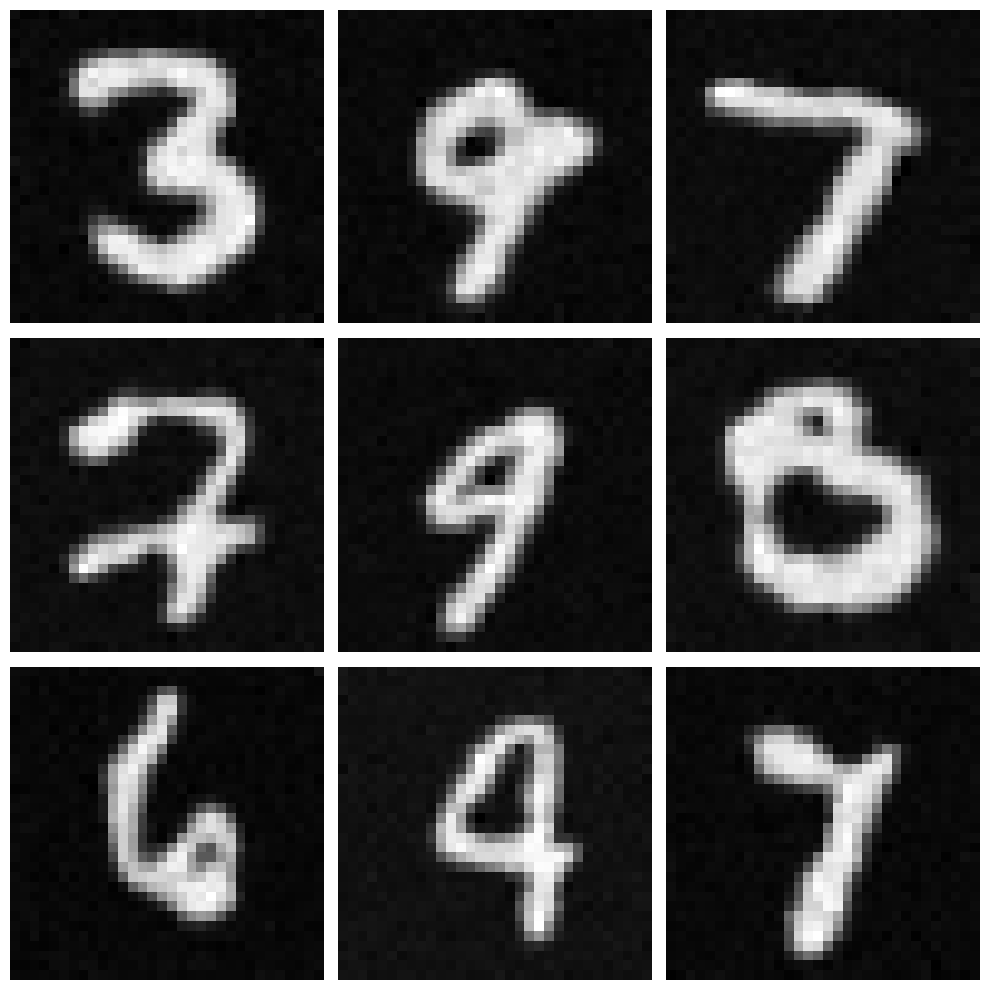

 90%|█████████ | 18/20 [34:22<03:49, 114.54s/it]

Loss: 0.014255035668611526
Loss: 0.015432705171406269
Loss: 0.01413161214441061
Loss: 0.014553683809936047
Loss: 0.013186421245336533
Loss: 0.014151601120829582
Loss: 0.013252672739326954
Loss: 0.01511987205594778
Loss: 0.016039442270994186
Loss: 0.013448011130094528
Loss: 0.012882276438176632
Loss: 0.01266767643392086
Loss: 0.011477282270789146
Loss: 0.014681650325655937
Loss: 0.012810829095542431
Loss: 0.015683157369494438
Loss: 0.01515417080372572
Loss: 0.015120238065719604
Loss: 0.013867666013538837
Loss: 0.011836852878332138
Loss: 0.013047173619270325
Loss: 0.012599801644682884
Loss: 0.013637128286063671
Loss: 0.014930748380720615
Loss: 0.014145825058221817
Loss: 0.014831924811005592
Loss: 0.017830748111009598
Loss: 0.012514030560851097
Loss: 0.015780020505189896
Loss: 0.015100255608558655
Loss: 0.016272325068712234
Loss: 0.015743479132652283
Loss: 0.015324591659009457
Loss: 0.013968096114695072
Loss: 0.014656328596174717
Loss: 0.015477734617888927
Loss: 0.0157584547996521
Loss: 0


100%|█████████▉| 995/1000 [00:19<00:00, 51.45it/s]

Showing/saving samples from epoch 18


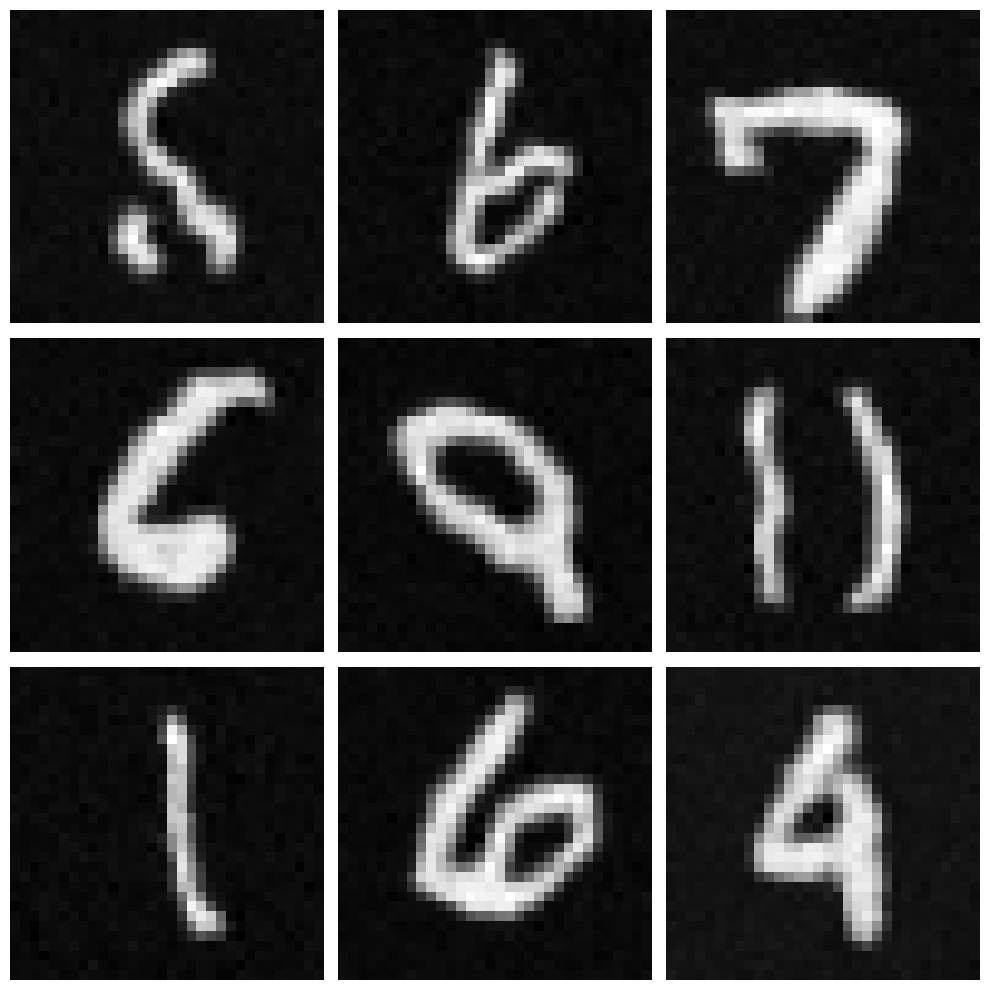

 95%|█████████▌| 19/20 [36:16<01:54, 114.50s/it]

Loss: 0.013462378643453121
Loss: 0.014191292226314545
Loss: 0.014557918533682823
Loss: 0.016531433910131454
Loss: 0.01199381798505783
Loss: 0.014278942719101906
Loss: 0.014825426042079926
Loss: 0.016310684382915497
Loss: 0.01774158701300621
Loss: 0.014987373724579811
Loss: 0.013960866257548332
Loss: 0.013233414851129055
Loss: 0.014422498643398285
Loss: 0.013057196512818336
Loss: 0.015803983435034752
Loss: 0.015807196497917175
Loss: 0.01542472280561924
Loss: 0.012673522345721722
Loss: 0.015763601288199425
Loss: 0.013102183118462563
Loss: 0.01621626317501068
Loss: 0.015368077903985977
Loss: 0.013638597913086414
Loss: 0.014425046741962433
Loss: 0.014682640321552753
Loss: 0.012562450021505356
Loss: 0.014981715008616447
Loss: 0.011777432635426521
Loss: 0.015358757227659225
Loss: 0.017648713663220406
Loss: 0.012768009677529335
Loss: 0.013200335204601288
Loss: 0.015396291390061378
Loss: 0.016014350578188896
Loss: 0.0163364689797163
Loss: 0.015594201162457466
Loss: 0.01597338728606701
Loss: 0.


100%|█████████▉| 995/1000 [00:19<00:00, 53.03it/s]

Showing/saving samples from epoch 19


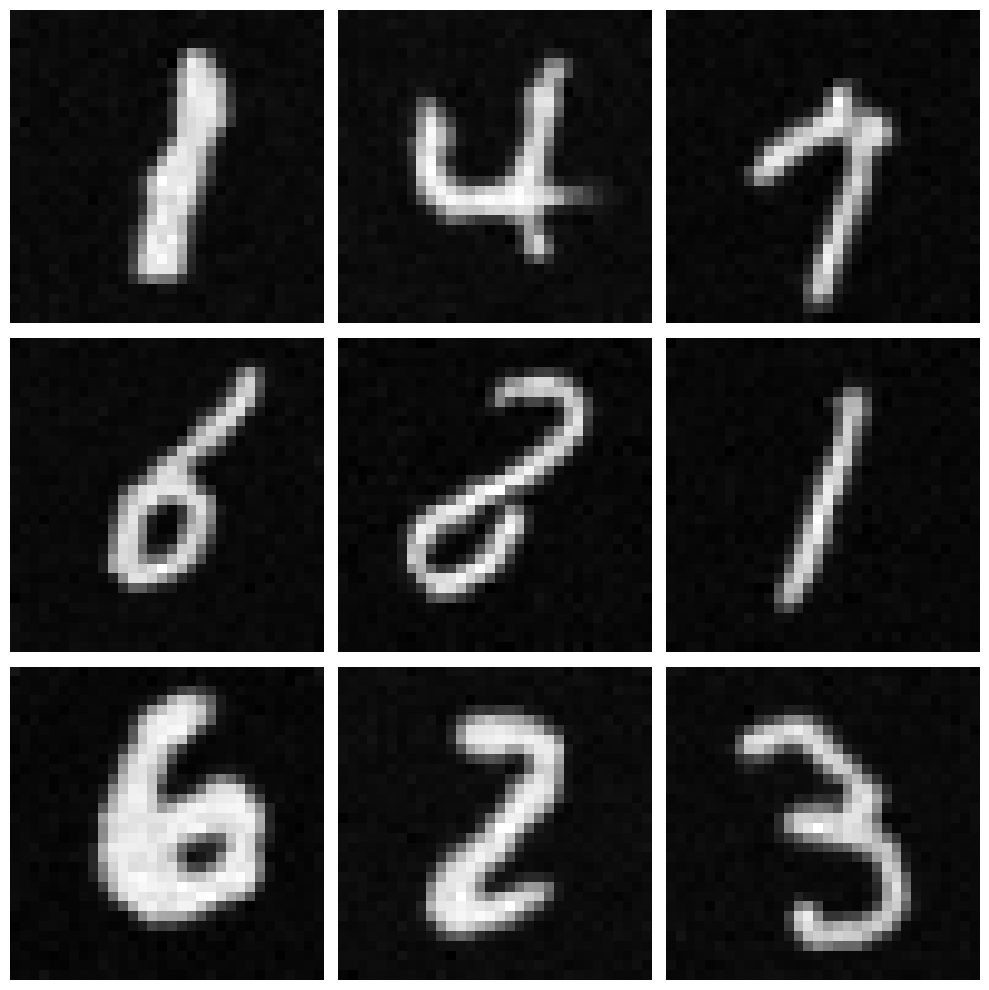

100%|██████████| 20/20 [38:10<00:00, 114.55s/it]


In [ ]:
trainer = Trainer(args, DenoiseDiffusion)
dataloader = torch.utils.data.DataLoader(
    MNISTDataset(),
    batch_size=args.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
)
trainer.run_in_a_row(dataloader)

# noise process examples


Visualize some images at different steps of the noising process

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()


def show_forward(ddpm, loader, device):
    # Showing the forward process after 25%, 50% , 75% and 100% of the noising steps
    for batch in loader:
        imgs = batch

        show_save(imgs,True, False)

        for percent in [0.25, 0.5, 0.75, 1]:
          t = int(percent * args.n_steps) - 1
          img_n =  ddpm.q_sample(imgs, torch.tensor(t))
          show_save(img_n,True, True,file_name=f"percent_{percent}_noise.png")
        break

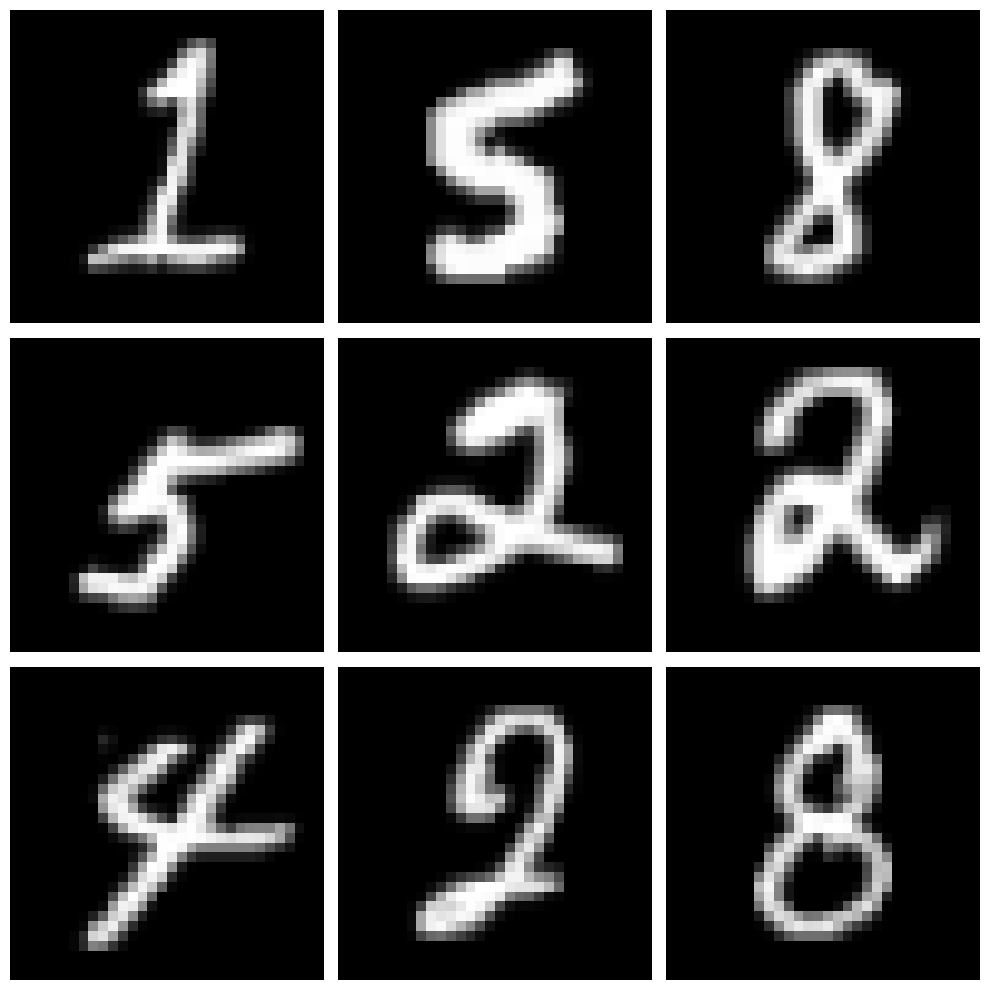

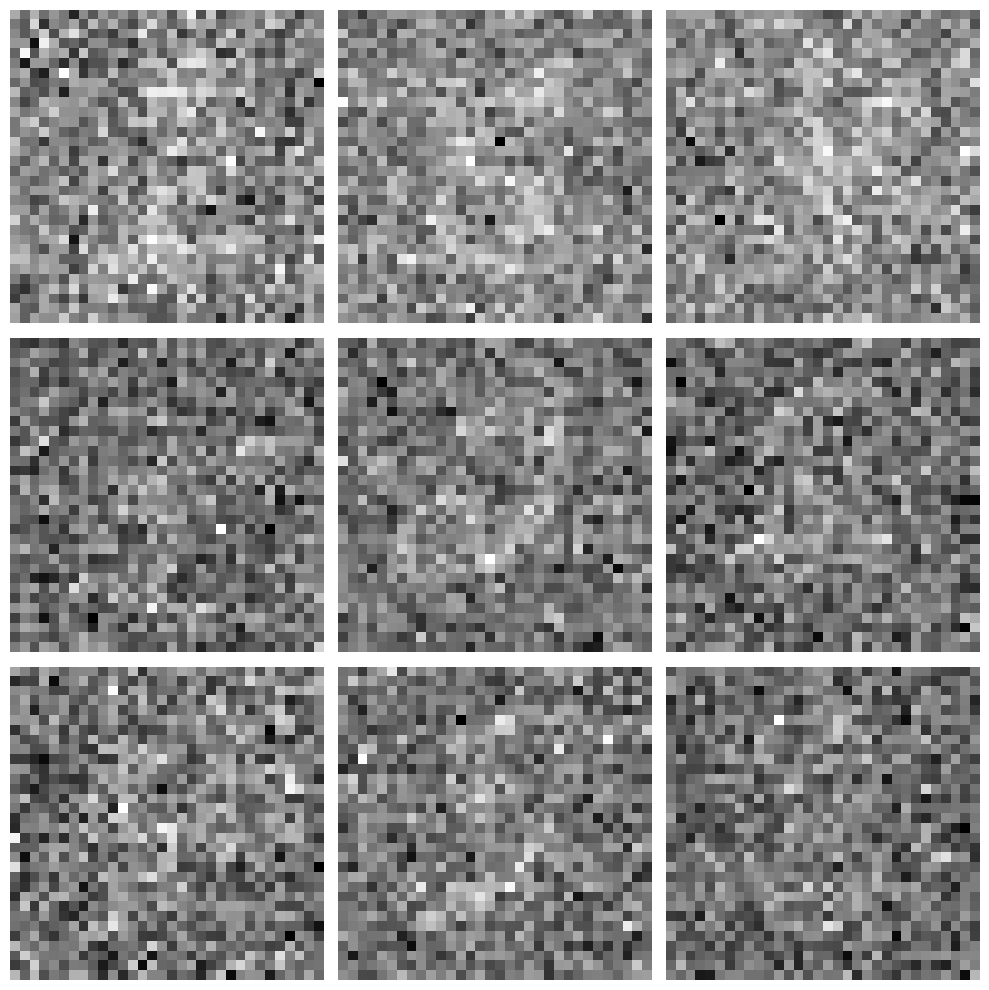

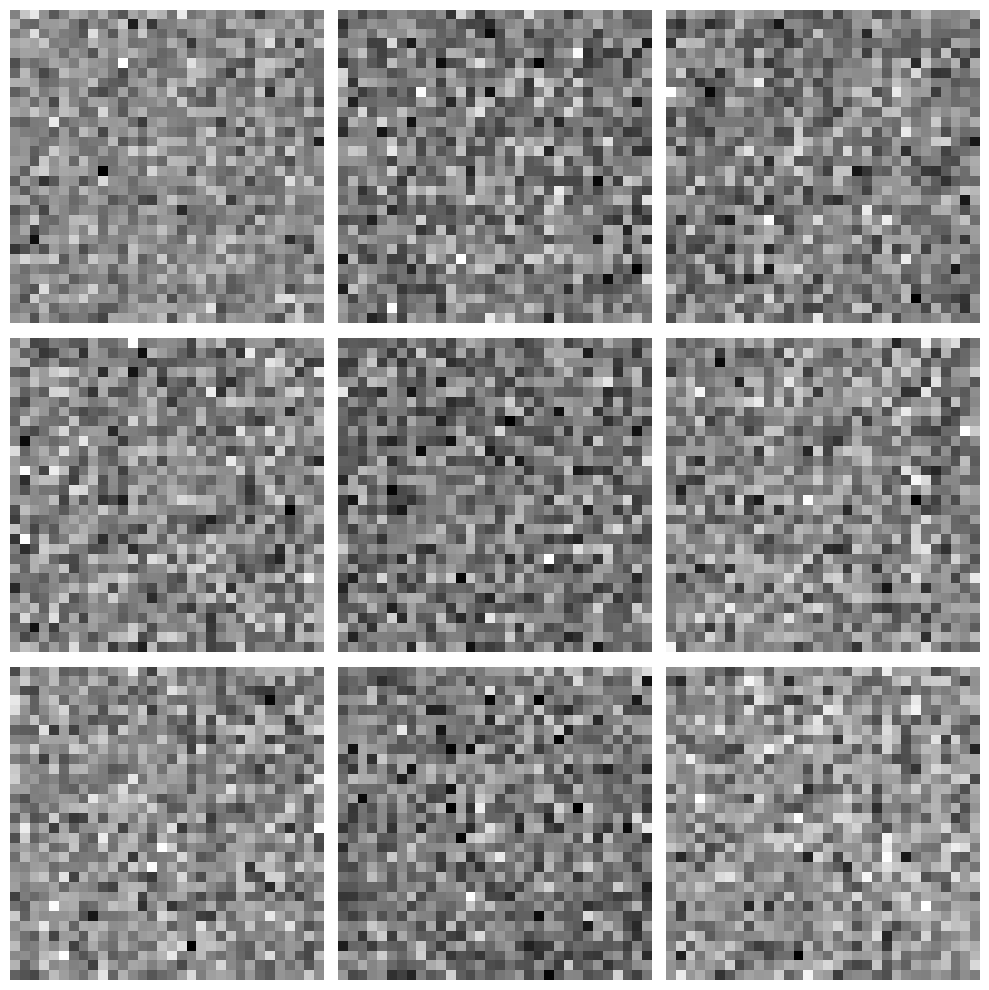

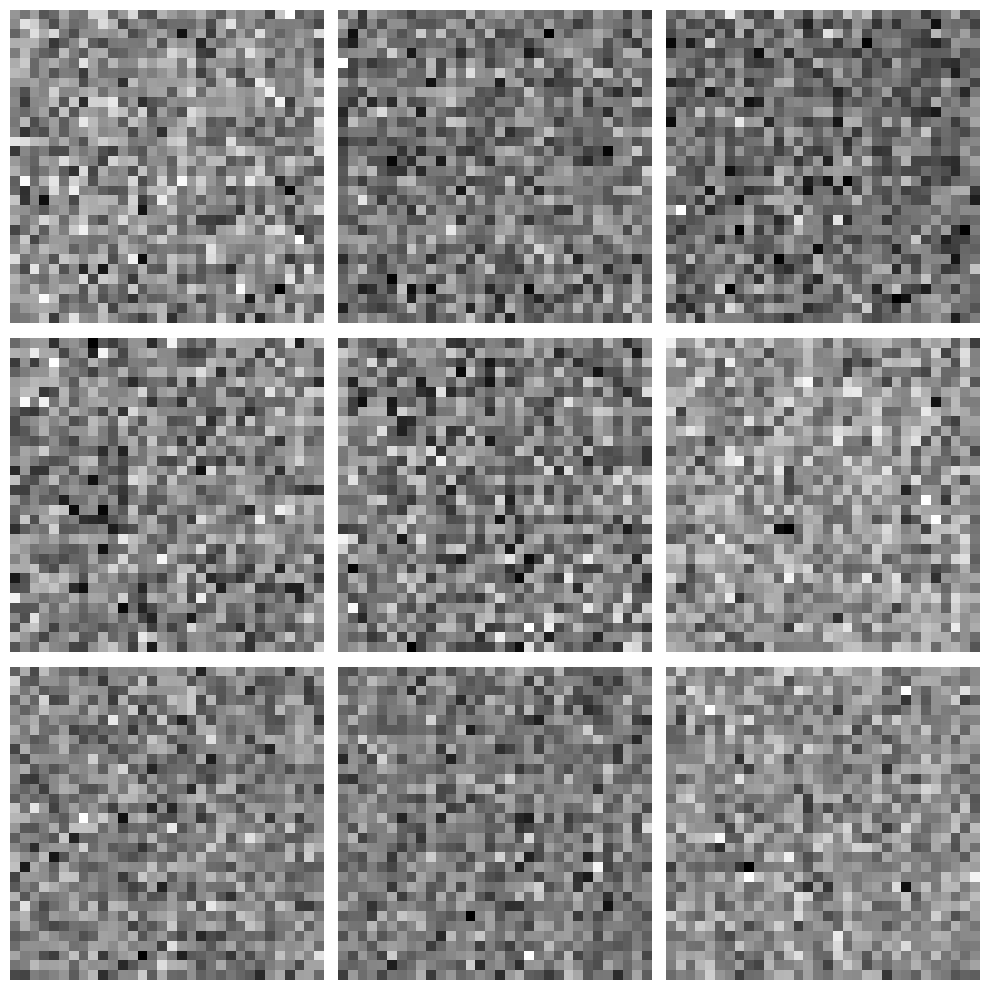

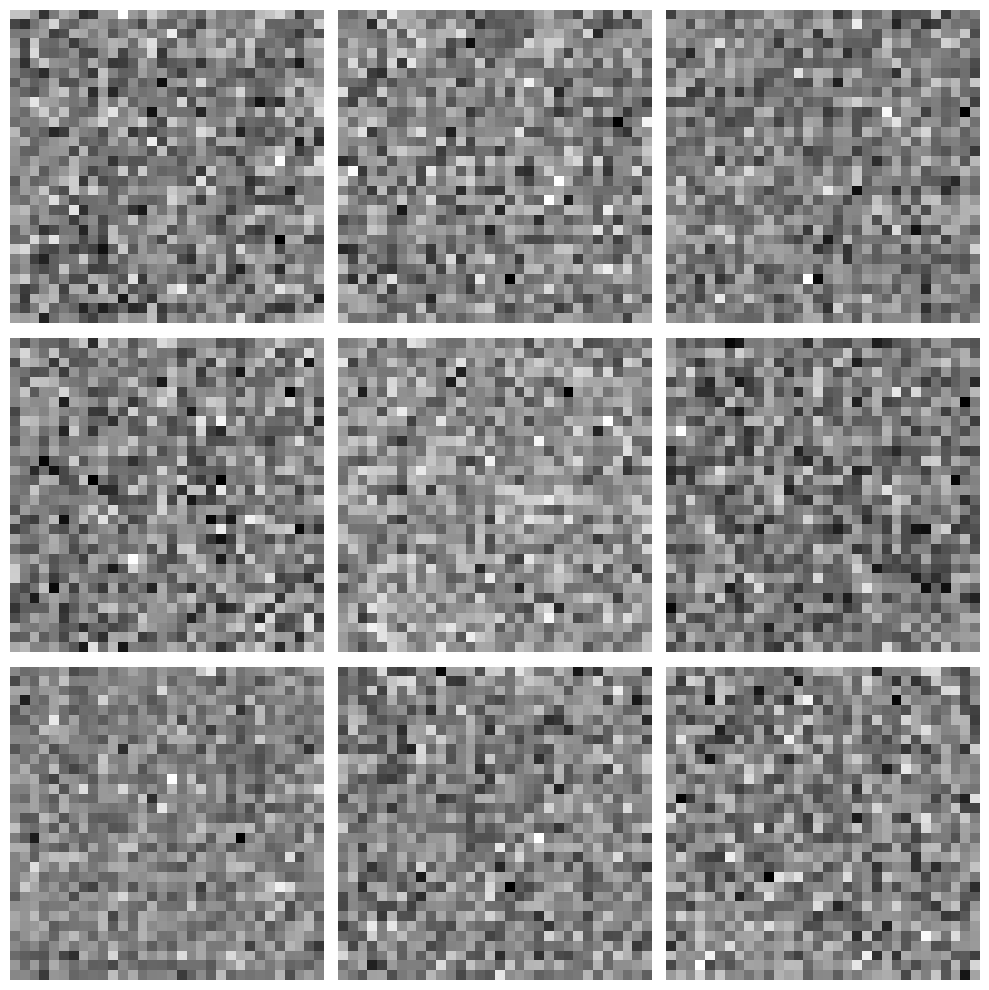

In [ ]:
ddpm = DenoiseDiffusion(eps_model=trainer.eps_model,
            n_steps=args.n_steps,
            device=args.device,)
show_forward(ddpm, dataloader, args.device)